# Predictive Modelling of COVID-19 Vaccinations by County

## Table of Contents

- 1. Overview
- 2. Data Understanding
- 3. Data Preparation
    - 3.a. CDC Vaccination Data
    - 3.b. Presidential Election Data
        - 3.b.ii. Creating the Combined DataFrame
    - 3.c. Poverty Data
    - 3.d. Census: Race
    - 3.e. Census: Age
    - 3.f. Education
    - 3.g. Dealing with Nulls
    - 3.h. Transforming a Categorical Column
    - 3.i. Binning the Target
    - 3.j. Saving the Cleaned Dataset
    - 3.k. Visualizing the Data
- 4. Modeling
    - 4.a. Dummy Model
    - 4.b. Decision Tree
        - 4.b.i. Baseline Decision Tree
        - 4.b.ii. Decision Tree Gridsearch
    - 4.c. Logarithmic Regression
        - 4.c.i. First Logarithmic Gridsearch
        - 4.c.ii. Second Logarithmic Gridsearch
    - 4.d. Random Forest
    - 4.e. Gradient Boosting
    - 4.f. AdaBoost
    - 4.g. Gradient Boosting II
    - 4.h. Gradient Boosting III
    - 4.i. Gradient Boosting IV
    - 4.j. Gradient Boosting V
- 5. Interpreting Our Results
- 6. Impact of the Model
- 7. Next Steps


## 1. Overview

Vaccinating a large percentage of the community is an essential portion of the response to the COVID-19 pandemic.

Three years from the vaccine roll-out, we now have a more complete picture of the disparity in vaccination rates among certain populations. One area of concern is the effect of partisan alignment on vaccination hesitance, especially in an increasingly polarized political sphere. The extensive discourse regarding medical misinformation and demographic-specific institutional distrust highlights a crucial area of research: what determines the likelihood of vaccination?

Examples of media covering this topic:

* [Kaiser Family Foundation: The Red-Blue Divide in COVID-19 Vaccination Rates Update](https://www.kff.org/policy-watch/the-red-blue-divide-in-covid-19-vaccination-rates-continues-an-update/)
* [NPR: There's A Stark Red-Blue Divide When It Comes To States' Vaccination Rates](https://www.npr.org/2021/06/09/1004430257/theres-a-stark-red-blue-divide-when-it-comes-to-states-vaccination-rates)

While we are inspired by and will pay particular attention to party-specific differences in vaccination rates, in order to build a more robust model we have gathered data on a multitude of factors that might affect vaccination rates.

Our research question is this: What factors best predict the rate of vaccination on a county-by-county level?

The stakeholders here are numerous: the federal government wants to direct its efforts to the appropriate counties; local governments want to make sure they have necessary resources; businesses want to ensure healthy employees and customers; the public benefits from lower rates of disease and mortality.

## 2. Data Understanding

We began with six datasets total, all providing data at the county-level. These datasets are provided below and in our data folder.

Our target variable is the latest (as of May 2023) available cumulative data on completed primary series vaccinations by county, from the CDC.

Our predictors are county-level demographic data: metro (urban) status from the same CDC dataset; 2020 Presidential election results from a github repository; race and age from the Census; poverty, median household income, and educational attainment from the USDA Economic Research Service.

* [CDC: COVID-19 Vaccinations by County](https://data.cdc.gov/Vaccinations/COVID-19-Vaccinations-in-the-United-States-County/8xkx-amqh/about_data) (468.8MB)
* [Census Datasets](https://www.census.gov/data/tables/time-series/demo/popest/2020s-counties-detail.html)
* [USDA Datasets](https://www.ers.usda.gov/data-products/county-level-data-sets/)
* [County-Level Election Results](https://github.com/tonmcg/US_County_Level_Election_Results_08-20)

## 3. Data Preparation

In [269]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

census_race = pd.read_csv('data/cc-est2022-all.csv', encoding="latin-1")
census_age = pd.read_csv('data/cc-est2022-agesex-all.csv')
vaccinations = pd.read_csv('data/COVID-19_Vaccinations_by_County.csv')
election = pd.read_csv('data/2020_US_County_Level_Presidential_Results.csv')
education = pd.read_excel('data/Education.xlsx')
poverty = pd.read_excel('data/PovertyEstimates.xlsx')

/var/folders/gf/gqtw2hsd3xx5_9tt2z47xflr0000gn/T/ipykernel_96793/1081371482.py:7: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  vaccinations = pd.read_csv('data/COVID-19_Vaccinations_by_County.csv')


### 3.a. CDC Vaccination Data

In [270]:
# First seeing how many total counties we have
# Grouping by state to avoid repeats given that some counties have the same name
vaccinations.groupby(by="Recip_State")["Recip_County"].value_counts()
# Note the "Unknown County" -- we'll have to remove those

Recip_State  Recip_County              
AK           Aleutians East Borough        598
             Aleutians West Census Area    598
             Yakutat City and Borough      598
             Yukon-Koyukuk Census Area     598
             Wrangell City and Borough     598
                                          ... 
WY           Teton County                  598
             Uinta County                  598
             Washakie County               598
             Weston County                 598
             Unknown County                595
Name: count, Length: 3284, dtype: int64

In [271]:
print('Number of states in CDC dataset: ', vaccinations["Recip_State"].value_counts().__len__())
print('Number of states in election dataset: ', election["state_name"].value_counts().__len__())

Number of states in CDC dataset:  60
Number of states in election dataset:  51


We also have more than the expected 51 states (including DC), since other territories -- e.g., Guam, Puerto Rico, and the Virgin Islands -- are included in the dataset. Since 2020 presidential election results will be a large part of our analysis, and since these territories don't have representation in the electoral college, we'll end up removing them.

In a similar vein, compare the counties in the CDC dataset for Alaska to the corresponding districts in Alaska for the election dataset:

In [272]:
vaccinations["Recip_County"][vaccinations["Recip_State"] == "AK"].head()


108          Yukon-Koyukuk Census Area
410                 Bethel Census Area
538                Bristol Bay Borough
615    Southeast Fairbanks Census Area
621           Yakutat City and Borough
Name: Recip_County, dtype: object

In [273]:
election["county_name"][election["state_name"] == "Alaska"].head()

67    District 1
68    District 2
69    District 3
70    District 4
71    District 5
Name: county_name, dtype: object

Alaska, unlike other states, counts its voting totals according to districts for the state's lower legislative chamber. As a result we have a geographic mismatch that makes it extremely difficult to effectively utilize data for Alaska. As a result, we'll define two custom functions: the first to remove territories and Alaska from our datasets; the second to concatenate the county and state names, to allow us to easily join our different datasets.

In [274]:
# Function to remove territories and Alaska
def drop_terrs(df, state):
    df = df[(df[state] != "PR") & (df[state] != "GU") & (df[state] != "VI") & (df[state] != "AK")]
    return df

# Function to concatenate county and state
def County_with_State(df, county, state):
    df["County_with_State"] = df[county] + ", " + df[state]

# Running both on our vaccination data
vaccinations = drop_terrs(vaccinations, "Recip_State")
County_with_State(vaccinations, "Recip_County", "Recip_State")

vaccinations["Recip_State"].value_counts().__len__()

56

We'll still have to remove a few more territories from the vaccination data, but this is a good start.

In [275]:
vaccinations["Recip_State"].value_counts().sort_values(ascending=True).head(10)

Recip_State
UNK     308
MH      581
PW      588
AS      589
MP      591
FM      594
DC     1192
DE     2389
HI     3264
RI     3585
Name: count, dtype: int64

We'll drop the first 6. `UNK` refers to unknown states; `MH` refers to the Marshall Islands; `PW` refers to Palau; `AS` refers to American Samoa; `MP` refers to the Northern Mariana Islands; `FM` refers to the Federated States of Micronesia. (Note: we're not including this in the above function since the other datasets don't include these locations.)

In [276]:
vaccinations = vaccinations[(vaccinations["Recip_State"] != "UNK") & 
                            (vaccinations["Recip_State"] != "MH") & 
                            (vaccinations["Recip_State"] != "PW") &
                            (vaccinations["Recip_State"] != "AS") &
                            (vaccinations["Recip_State"] != "MP") &
                            (vaccinations["Recip_State"] != "FM")]
vaccinations["Recip_State"].value_counts().__len__()

50

In [277]:
# Also removing the "Unknown County" rows
vaccinations = vaccinations[vaccinations["Recip_County"] != "Unknown County"]
vaccinations["County_with_State"].value_counts()

County_with_State
Washburn County, WI        598
Winnebago County, IL       598
East Carroll Parish, LA    598
Madison County, AL         598
Slope County, ND           598
                          ... 
Chariton County, MO        598
Botetourt County, VA       598
Marion County, TN          598
Wallace County, KS         598
Santa Rosa County, FL      598
Name: count, Length: 3113, dtype: int64

This leaves us with 50 states (since we're keeping DC and dropping Alaska) and **3,113 unique counties**, each with 598 entries.

We'll now take a look at why exactly each county has so many entries:

In [278]:
vaccinations[vaccinations["County_with_State"] == "Saginaw County, MI"]

,Date,FIPS,MMWR_week,Recip_County,Recip_State,Completeness_pct,Administered_Dose1_Recip,Administered_Dose1_Pop_Pct,Administered_Dose1_Recip_5Plus,Administered_Dose1_Recip_5PlusPop_Pct,...,Census2019_65PlusPop,Bivalent_Booster_5Plus,Bivalent_Booster_5Plus_Pop_Pct,Bivalent_Booster_12Plus,Bivalent_Booster_12Plus_Pop_Pct,Bivalent_Booster_18Plus,Bivalent_Booster_18Plus_Pop_Pct,Bivalent_Booster_65Plus,Bivalent_Booster_65Plus_Pop_Pct,County_with_State
4,05/10/2023,26145,19,Saginaw County,MI,94.0,104075.0,54.6,NaN,NaN,...,37414.0,15618.0,8.7,15448.0,9.4,15112.0,10.1,7921.0,21.2,"Saginaw County, MI"
4563,05/03/2023,26145,18,Saginaw County,MI,94.0,104069.0,54.6,NaN,NaN,...,37414.0,15564.0,8.7,15394.0,9.4,15059.0,10.1,7884.0,21.1,"Saginaw County, MI"
7366,04/26/2023,26145,17,Saginaw County,MI,94.0,104066.0,54.6,NaN,NaN,...,37414.0,15535.0,8.7,15366.0,9.4,15034.0,10.0,7864.0,21.0,"Saginaw County, MI"
10458,04/19/2023,26145,16,Saginaw County,MI,94.0,104063.0,54.6,NaN,NaN,...,37414.0,15504.0,8.6,15336.0,9.4,15004.0,10.0,7843.0,21.0,"Saginaw County, MI"
15810,04/12/2023,26145,15,Saginaw County,MI,94.1,104065.0,54.6,NaN,NaN,...,37414.0,15523.0,8.6,15357.0,9.4,15025.0,10.0,7840.0,21.0,"Saginaw County, MI"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1949775,12/17/2020,26145,51,Saginaw County,MI,0.0,0.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Saginaw County, MI"
1951790,12/16/2020,26145,51,Saginaw County,MI,0.0,0.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Saginaw County, MI"
1954312,12/15/2020,26145,51,Saginaw County,MI,0.0,0.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Saginaw County, MI"
1959148,12/14/2020,26145,51,Saginaw County,MI,0.0,0.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Saginaw County, MI"


For our purposes, we just want the percentage of everyone in the county who has completed their primary vaccination series -- so we will simply take the most recent data, from 05/10/2023.

In [279]:
vaccinations = vaccinations[(vaccinations["Date"] == "05/10/2023")]
vaccinations

,Date,FIPS,MMWR_week,Recip_County,Recip_State,Completeness_pct,Administered_Dose1_Recip,Administered_Dose1_Pop_Pct,Administered_Dose1_Recip_5Plus,Administered_Dose1_Recip_5PlusPop_Pct,...,Census2019_65PlusPop,Bivalent_Booster_5Plus,Bivalent_Booster_5Plus_Pop_Pct,Bivalent_Booster_12Plus,Bivalent_Booster_12Plus_Pop_Pct,Bivalent_Booster_18Plus,Bivalent_Booster_18Plus_Pop_Pct,Bivalent_Booster_65Plus,Bivalent_Booster_65Plus_Pop_Pct,County_with_State
0,05/10/2023,55129,19,Washburn County,WI,96.7,11123.0,70.8,11097.0,73.9,...,4304.0,3978.0,26.5,3955.0,28.6,3899.0,30.6,2588.0,60.1,"Washburn County, WI"
1,05/10/2023,19173,19,Taylor County,IA,97.3,3149.0,51.4,3145.0,55.0,...,1392.0,841.0,14.7,841.0,16.3,834.0,17.8,588.0,42.2,"Taylor County, IA"
2,05/10/2023,36059,19,Nassau County,NY,97.5,1391226.0,95.0,1384503.0,95.0,...,246690.0,236202.0,18.4,231748.0,19.8,224931.0,21.1,109947.0,44.6,"Nassau County, NY"
3,05/10/2023,48281,19,Lampasas County,TX,98.9,11678.0,54.5,11660.0,57.4,...,4322.0,1951.0,9.6,1947.0,10.5,1925.0,11.5,1229.0,28.4,"Lampasas County, TX"
4,05/10/2023,26145,19,Saginaw County,MI,94.0,104075.0,54.6,NaN,NaN,...,37414.0,15618.0,8.7,15448.0,9.4,15112.0,10.1,7921.0,21.2,"Saginaw County, MI"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3278,05/10/2023,29153,19,Ozark County,MO,91.3,3762.0,41.0,3760.0,42.9,...,2684.0,732.0,8.4,730.0,9.0,724.0,9.8,512.0,19.1,"Ozark County, MO"
3279,05/10/2023,46065,19,Hughes County,SD,96.7,16373.0,93.4,16308.0,95.0,...,3158.0,3659.0,22.4,3601.0,24.7,3499.0,26.3,1857.0,58.8,"Hughes County, SD"
3280,05/10/2023,26027,19,Cass County,MI,94.0,26815.0,51.8,NaN,NaN,...,11149.0,3330.0,6.8,3293.0,7.3,3219.0,7.8,1822.0,16.3,"Cass County, MI"
3281,05/10/2023,32001,19,Churchill County,NV,95.1,16252.0,65.2,16164.0,69.5,...,4759.0,2576.0,11.1,2544.0,12.1,2475.0,12.9,1439.0,30.2,"Churchill County, NV"


We're left with 3,113 rows, corresponding to 1 entry per unique county. We are only interested in the vaccination percentages (our target) and the metro status from this dataset, so we will subset those columns.

We are keeping the metro status in order to examine whether the inherent difference in healthcare, transportation, administration, etc. infrastructure in urban vs. rural areas affects our target.

In [280]:
"""
From this dataset, we just want to include:
* Date
* County_with_State
* Series_Complete_Pop_Pct
* Metro_status
"""

vaccinations = vaccinations[["Date", "County_with_State", "Series_Complete_Pop_Pct", "Metro_status"]]
vaccinations

,Date,County_with_State,Series_Complete_Pop_Pct,Metro_status
0,05/10/2023,"Washburn County, WI",65.7,Non-metro
1,05/10/2023,"Taylor County, IA",48.2,Non-metro
2,05/10/2023,"Nassau County, NY",86.9,Metro
3,05/10/2023,"Lampasas County, TX",46.7,Metro
4,05/10/2023,"Saginaw County, MI",54.1,Metro
...,...,...,...,...
3278,05/10/2023,"Ozark County, MO",33.3,Non-metro
3279,05/10/2023,"Hughes County, SD",76.8,Non-metro
3280,05/10/2023,"Cass County, MI",45.7,Metro
3281,05/10/2023,"Churchill County, NV",56.3,Non-metro


### 3.b. Presidential Election Data

The voting percentages for each party in the 2020 presidential election will be our proxy for political affiliation.

In [281]:
election.head()

,state_name,county_fips,county_name,votes_gop,votes_dem,total_votes,diff,per_gop,per_dem,per_point_diff
0,Alabama,1001,Autauga County,19838,7503,27770,12335,0.714368,0.270184,0.444184
1,Alabama,1003,Baldwin County,83544,24578,109679,58966,0.761714,0.224090,0.537623
2,Alabama,1005,Barbour County,5622,4816,10518,806,0.534512,0.457882,0.076631
3,Alabama,1007,Bibb County,7525,1986,9595,5539,0.784263,0.206983,0.577280
4,Alabama,1009,Blount County,24711,2640,27588,22071,0.895716,0.095694,0.800022


In [282]:
# Adding a third_party column
election["votes_third_party"] = election["total_votes"] - election["votes_dem"] - election["votes_gop"]

# Rounding percentages
election["per_third_party"] = round(100 * election["votes_third_party"] / election["total_votes"], 1)
election['per_gop'] = round(100 * election['per_gop'], 1)
election['per_dem'] = round(100 * election['per_dem'], 1)


In [283]:
# Adding a state abbreviation column
# Necessary for our drop_terrs and County_with_State functions to work
# adding a state_abbrev column
state_abbrevs = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    "District of Columbia": "DC",
    "American Samoa": "AS",
    "Guam": "GU",
    "Northern Mariana Islands": "MP",
    "Puerto Rico": "PR",
    "United States Minor Outlying Islands": "UM",
    "U.S. Virgin Islands": "VI",
}

election["state_abbrev"] = election["state_name"].map(state_abbrevs)
election["state_abbrev"].head()

0    AL
1    AL
2    AL
3    AL
4    AL
Name: state_abbrev, dtype: object

In [284]:
election = drop_terrs(election, "state_abbrev")
County_with_State(election, "county_name", "state_abbrev")
num_states = election["state_abbrev"].value_counts().__len__()
num_counties = election["County_with_State"].value_counts().__len__()

print('Number of states in election dataset: ', num_states)
print('Number of unique counties in election dataset: ', num_counties)

Number of states in election dataset:  50
Number of unique counties in election dataset:  3112


We're going to have to compare which counties appear in two datasets a lot, so we'll define a function that allows us to do that quickly:

In [285]:
# Function to automatically compare difference in counties:
def check_overlap(df1, df2, column):
    vc1 = pd.DataFrame(df1[column])
    vc2 = pd.DataFrame(df2[column])
    combined = pd.merge(vc1, vc2, how="outer", indicator=True)
    combined_right = combined[combined["_merge"] == "right_only"]
    combined_left = combined[combined["_merge"] == "left_only"]
    return combined_right.value_counts(), combined_left.value_counts()

check_overlap(election, vaccinations, "County_with_State")

(County_with_State    _merge    
 Dona Ana County, NM  right_only    1
 Kalawao County, HI   right_only    1
 La Salle Parish, LA  right_only    1
 Name: count, dtype: int64,
 County_with_State    _merge   
 Doña Ana County, NM  left_only    1
 LaSalle Parish, LA   left_only    1
 Name: count, dtype: int64)

In [286]:
election

,state_name,county_fips,county_name,votes_gop,votes_dem,total_votes,diff,per_gop,per_dem,per_point_diff,votes_third_party,per_third_party,state_abbrev,County_with_State
0,Alabama,1001,Autauga County,19838,7503,27770,12335,71.4,27.0,0.444184,429,1.5,AL,"Autauga County, AL"
1,Alabama,1003,Baldwin County,83544,24578,109679,58966,76.2,22.4,0.537623,1557,1.4,AL,"Baldwin County, AL"
2,Alabama,1005,Barbour County,5622,4816,10518,806,53.5,45.8,0.076631,80,0.8,AL,"Barbour County, AL"
3,Alabama,1007,Bibb County,7525,1986,9595,5539,78.4,20.7,0.577280,84,0.9,AL,"Bibb County, AL"
4,Alabama,1009,Blount County,24711,2640,27588,22071,89.6,9.6,0.800022,237,0.9,AL,"Blount County, AL"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3147,Wyoming,56037,Sweetwater County,12229,3823,16603,8406,73.7,23.0,0.506294,551,3.3,WY,"Sweetwater County, WY"
3148,Wyoming,56039,Teton County,4341,9848,14677,-5507,29.6,67.1,-0.375213,488,3.3,WY,"Teton County, WY"
3149,Wyoming,56041,Uinta County,7496,1591,9402,5905,79.7,16.9,0.628058,315,3.4,WY,"Uinta County, WY"
3150,Wyoming,56043,Washakie County,3245,651,4012,2594,80.9,16.2,0.646560,116,2.9,WY,"Washakie County, WY"


In [287]:
# Renaming the different county names to match
election["County_with_State"] = election["County_with_State"].replace("Doña Ana County, NM", "Dona Ana County, NM")
election["county_name"] = election["county_name"].replace("Doña Ana County", "Dona Ana County")
election["County_with_State"] = election["County_with_State"].replace("LaSalle Parish, LA", "La Salle Parish, LA")
election["county_name"] = election["county_name"].replace("LaSalle Parish", "La Salle Parish")

# Manually imputing the values for Kalawao County, HI
election.loc[-1] = {"state_name": "Hawaii", "county_name": "Kalawao County", "total_votes": 24, "votes_dem": 23, "votes_gop": 1, "votes_third_party": 0, "per_dem": 95.8, "per_gop": 4.2, "per_third_party": 0, "state_abbrev": "HI", "County_with_State": "Kalawao County, HI"}


In [288]:
election[election["County_with_State"] == "Kalawao County, HI"]

,state_name,county_fips,county_name,votes_gop,votes_dem,total_votes,diff,per_gop,per_dem,per_point_diff,votes_third_party,per_third_party,state_abbrev,County_with_State
-1,Hawaii,NaN,Kalawao County,1,23,24,NaN,4.2,95.8,NaN,0,0.0,HI,"Kalawao County, HI"


In [289]:
# gets us back to 3,113 counties
election["County_with_State"].value_counts().__len__()

3113

In [290]:
# Just selecting the columns we want
election = election[["per_gop", "per_dem", "per_third_party", "County_with_State"]]
election.head()

,per_gop,per_dem,per_third_party,County_with_State
0,71.4,27.0,1.5,"Autauga County, AL"
1,76.2,22.4,1.4,"Baldwin County, AL"
2,53.5,45.8,0.8,"Barbour County, AL"
3,78.4,20.7,0.9,"Bibb County, AL"
4,89.6,9.6,0.9,"Blount County, AL"


In [291]:
election.isna().sum()

per_gop              0
per_dem              0
per_third_party      0
County_with_State    0
dtype: int64

#### 3.b.ii. Creating the Combined DataFrame

In [292]:
# Making the combined df

df = pd.merge(election, vaccinations, how="inner", on="County_with_State")
df

,per_gop,per_dem,per_third_party,County_with_State,Date,Series_Complete_Pop_Pct,Metro_status
0,71.4,27.0,1.5,"Autauga County, AL",05/10/2023,46.1,Metro
1,76.2,22.4,1.4,"Baldwin County, AL",05/10/2023,53.4,Metro
2,53.5,45.8,0.8,"Barbour County, AL",05/10/2023,47.4,Non-metro
3,78.4,20.7,0.9,"Bibb County, AL",05/10/2023,36.5,Metro
4,89.6,9.6,0.9,"Blount County, AL",05/10/2023,32.9,Metro
...,...,...,...,...,...,...,...
3108,29.6,67.1,3.3,"Teton County, WY",05/10/2023,95.0,Non-metro
3109,79.7,16.9,3.4,"Uinta County, WY",05/10/2023,54.0,Non-metro
3110,80.9,16.2,2.9,"Washakie County, WY",05/10/2023,45.2,Non-metro
3111,87.7,10.2,2.1,"Weston County, WY",05/10/2023,39.1,Non-metro


### 3.c. Poverty Data

We are interested in whether socioeconomic status affects likelihood of vaccination. If someone is poorer, are they less likely to seek medical care? To explore this, we will add in the percentage of persons in poverty in a county as a predictor.

Later we will also add another socioeconomic factor as a predictor: median household income.

In [293]:
poverty.head()

,"Poverty estimates for U.S., States, and counties, 2021",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33
0,"Source: U.S. Department of Commerce, Bureau of...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"For definitions of rural classifications, see ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"This table was prepared by USDA, Economic Rese...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,FIPS_Code,Stabr,Area_name,Rural-urban_Continuum_Code_2003,Urban_Influence_Code_2003,Rural-urban_Continuum_Code_2013,Urban_Influence_Code_ 2013,POVALL_2021,CI90LBALL_2021,CI90UBALL_2021,...,CI90UB517P_2021,MEDHHINC_2021,CI90LBINC_2021,CI90UBINC_2021,POV04_2021,CI90LB04_2021,CI90UB04_2021,PCTPOV04_2021,CI90LB04P_2021,CI90UB04P_2021
4,00000,US,United States,NaN,NaN,NaN,NaN,41393176,41149497,41636855,...,16.3,69717,69583,69851,3349149,3299669,3398629,18.3,18,18.6



In this dataset, the first four rows are headers rather than data themselves. We need to reset things so that row 3 is the header.

We will also run our standard two functions on this dataset: the removal of U.S. territories and Alaska, and the concatenation of the county names with state abbreviations.

In [294]:
# Fixing column names and removing the initial rows
poverty.columns = poverty.iloc[3]
poverty.drop(poverty.index[0:5], inplace=True)

# Dropping territories and Alaska
poverty = drop_terrs(poverty, "Stabr")

# Creating our County_with_State column
County_with_State(poverty, "Area_name", "Stabr")
poverty.head()

3,FIPS_Code,Stabr,Area_name,Rural-urban_Continuum_Code_2003,Urban_Influence_Code_2003,Rural-urban_Continuum_Code_2013,Urban_Influence_Code_ 2013,POVALL_2021,CI90LBALL_2021,CI90UBALL_2021,...,MEDHHINC_2021,CI90LBINC_2021,CI90UBINC_2021,POV04_2021,CI90LB04_2021,CI90UB04_2021,PCTPOV04_2021,CI90LB04P_2021,CI90UB04P_2021,County_with_State
5,01000,AL,Alabama,NaN,NaN,NaN,NaN,800848,782169,819527,...,53990,53218,54762,71220,66888,75552,25.1,23.6,26.6,"Alabama, AL"
6,01001,AL,Autauga County,2,2,2,2,6296,4772,7820,...,66444,60061,72827,NaN,NaN,NaN,NaN,NaN,NaN,"Autauga County, AL"
7,01003,AL,Baldwin County,4,5,3,2,25526,21599,29453,...,65658,60723,70593,NaN,NaN,NaN,NaN,NaN,NaN,"Baldwin County, AL"
8,01005,AL,Barbour County,6,6,6,6,5089,3773,6405,...,38649,34308,42990,NaN,NaN,NaN,NaN,NaN,NaN,"Barbour County, AL"
9,01007,AL,Bibb County,1,1,1,1,4204,3324,5084,...,48454,42438,54470,NaN,NaN,NaN,NaN,NaN,NaN,"Bibb County, AL"


In [295]:
# Checking overlap with combined df
check_overlap(df, poverty, "County_with_State")

(County_with_State    _merge    
 Alabama, AL          right_only    1
 Oregon, OR           right_only    1
 Montana, MT          right_only    1
 Nebraska, NE         right_only    1
 Nevada, NV           right_only    1
 New Hampshire, NH    right_only    1
 New Jersey, NJ       right_only    1
 New Mexico, NM       right_only    1
 New York, NY         right_only    1
 North Carolina, NC   right_only    1
 North Dakota, ND     right_only    1
 Ohio, OH             right_only    1
 Oklahoma, OK         right_only    1
 Pennsylvania, PA     right_only    1
 Mississippi, MS      right_only    1
 Rhode Island, RI     right_only    1
 South Carolina, SC   right_only    1
 South Dakota, SD     right_only    1
 Tennessee, TN        right_only    1
 Texas, TX            right_only    1
 Utah, UT             right_only    1
 Vermont, VT          right_only    1
 Virginia, VA         right_only    1
 Washington, WA       right_only    1
 West Virginia, WV    right_only    1
 Wisconsin, WI   

The results of our comparison function for counties in each dataset show first that the 'right' dataset (our poverty dataset) contains aggregate, state-wide rows. We remove those below.

In [296]:
state_names = ["Alaska", "Alabama", "Arkansas", "American Samoa", "Arizona", "California", "Colorado", "Connecticut", "Delaware", "Florida", "Georgia", "Guam", "Hawaii", "Iowa", "Idaho", "Illinois", "Indiana", "Kansas", "Kentucky", "Louisiana", "Massachusetts", "Maryland", "Maine", "Michigan", "Minnesota", "Missouri", "Mississippi", "Montana", "North Carolina", "North Dakota", "Nebraska", "New Hampshire", "New Jersey", "New Mexico", "Nevada", "New York", "Ohio", "Oklahoma", "Oregon", "Pennsylvania", "Puerto Rico", "Rhode Island", "South Carolina", "South Dakota", "Tennessee", "Texas", "Utah", "Virginia", "Virgin Islands", "Vermont", "Washington", "Wisconsin", "West Virginia", "Wyoming"]
poverty.drop(poverty.index[poverty["Area_name"].isin(state_names)], inplace=True)
poverty

3,FIPS_Code,Stabr,Area_name,Rural-urban_Continuum_Code_2003,Urban_Influence_Code_2003,Rural-urban_Continuum_Code_2013,Urban_Influence_Code_ 2013,POVALL_2021,CI90LBALL_2021,CI90UBALL_2021,...,MEDHHINC_2021,CI90LBINC_2021,CI90UBINC_2021,POV04_2021,CI90LB04_2021,CI90UB04_2021,PCTPOV04_2021,CI90LB04P_2021,CI90UB04P_2021,County_with_State
6,01001,AL,Autauga County,2,2,2,2,6296,4772,7820,...,66444,60061,72827,NaN,NaN,NaN,NaN,NaN,NaN,"Autauga County, AL"
7,01003,AL,Baldwin County,4,5,3,2,25526,21599,29453,...,65658,60723,70593,NaN,NaN,NaN,NaN,NaN,NaN,"Baldwin County, AL"
8,01005,AL,Barbour County,6,6,6,6,5089,3773,6405,...,38649,34308,42990,NaN,NaN,NaN,NaN,NaN,NaN,"Barbour County, AL"
9,01007,AL,Bibb County,1,1,1,1,4204,3324,5084,...,48454,42438,54470,NaN,NaN,NaN,NaN,NaN,NaN,"Bibb County, AL"
10,01009,AL,Blount County,1,1,1,1,6992,5516,8468,...,56894,52632,61156,NaN,NaN,NaN,NaN,NaN,NaN,"Blount County, AL"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3194,56037,WY,Sweetwater County,5,8,5,8,3761,3048,4474,...,74677,66928,82426,NaN,NaN,NaN,NaN,NaN,NaN,"Sweetwater County, WY"
3195,56039,WY,Teton County,7,8,7,8,1392,1070,1714,...,102709,90132,115286,NaN,NaN,NaN,NaN,NaN,NaN,"Teton County, WY"
3196,56041,WY,Uinta County,7,8,7,8,1917,1457,2377,...,70162,62206,78118,NaN,NaN,NaN,NaN,NaN,NaN,"Uinta County, WY"
3197,56043,WY,Washakie County,7,11,7,11,773,579,967,...,62176,55415,68937,NaN,NaN,NaN,NaN,NaN,NaN,"Washakie County, WY"


In [297]:
# DC is listed twice, so only keeping the first instance
# Gets us to our 3,113 unique counties
poverty = poverty.drop_duplicates(subset=["County_with_State"], keep="first")
poverty["County_with_State"].value_counts().__len__()

3113

From the poverty dataset, we only want to include the following columns:

PCTPOVALL_2021, the overall percentage of people in poverty in 2021
MEDHHINC_2021, the "estimate of median household income 2021"
County_with_State, the column we merge on

In [298]:

poverty = poverty[["PCTPOVALL_2021", "MEDHHINC_2021", "County_with_State"]]
poverty

3,PCTPOVALL_2021,MEDHHINC_2021,County_with_State
6,10.7,66444,"Autauga County, AL"
7,10.8,65658,"Baldwin County, AL"
8,23,38649,"Barbour County, AL"
9,20.6,48454,"Bibb County, AL"
10,12,56894,"Blount County, AL"
...,...,...,...
3194,9.2,74677,"Sweetwater County, WY"
3195,5.9,102709,"Teton County, WY"
3196,9.4,70162,"Uinta County, WY"
3197,10.2,62176,"Washakie County, WY"


In [299]:
# Checking overlap with our combined df:
check_overlap(df, poverty, "County_with_State")

(County_with_State    _merge    
 De Kalb County, IN   right_only    1
 DeBaca County, NM    right_only    1
 La Porte County, IN  right_only    1
 La Salle County, IL  right_only    1
 Lagrange County, IN  right_only    1
 Mc Kean County, PA   right_only    1
 Name: count, dtype: int64,
 County_with_State    _merge   
 De Baca County, NM   left_only    1
 DeKalb County, IN    left_only    1
 LaGrange County, IN  left_only    1
 LaPorte County, IN   left_only    1
 LaSalle County, IL   left_only    1
 McKean County, PA    left_only    1
 Name: count, dtype: int64)

In [300]:
# Fixing county names
poverty["County_with_State"] = poverty["County_with_State"].replace("De Kalb County, IN", "DeKalb County, IN")
poverty["County_with_State"] = poverty["County_with_State"].replace("DeBaca County, NM", "De Baca County, NM")
poverty["County_with_State"] = poverty["County_with_State"].replace("La Porte County, IN", "LaPorte County, IN")
poverty["County_with_State"] = poverty["County_with_State"].replace("La Salle County, IL", "LaSalle County, IL")
poverty["County_with_State"] = poverty["County_with_State"].replace("Lagrange County, IN", "LaGrange County, IN")
poverty["County_with_State"] = poverty["County_with_State"].replace("Mc Kean County, PA", "McKean County, PA")

check_overlap(df, poverty, "County_with_State")

(Series([], Name: count, dtype: int64), Series([], Name: count, dtype: int64))

In [301]:
# Merging with our combined dataframe:
df = pd.merge(df, poverty, how="inner", on="County_with_State")
df

,per_gop,per_dem,per_third_party,County_with_State,Date,Series_Complete_Pop_Pct,Metro_status,PCTPOVALL_2021,MEDHHINC_2021
0,71.4,27.0,1.5,"Autauga County, AL",05/10/2023,46.1,Metro,10.7,66444
1,76.2,22.4,1.4,"Baldwin County, AL",05/10/2023,53.4,Metro,10.8,65658
2,53.5,45.8,0.8,"Barbour County, AL",05/10/2023,47.4,Non-metro,23,38649
3,78.4,20.7,0.9,"Bibb County, AL",05/10/2023,36.5,Metro,20.6,48454
4,89.6,9.6,0.9,"Blount County, AL",05/10/2023,32.9,Metro,12,56894
...,...,...,...,...,...,...,...,...,...
3108,29.6,67.1,3.3,"Teton County, WY",05/10/2023,95.0,Non-metro,5.9,102709
3109,79.7,16.9,3.4,"Uinta County, WY",05/10/2023,54.0,Non-metro,9.4,70162
3110,80.9,16.2,2.9,"Washakie County, WY",05/10/2023,45.2,Non-metro,10.2,62176
3111,87.7,10.2,2.1,"Weston County, WY",05/10/2023,39.1,Non-metro,10.4,62509


### 3.d. Census: Race

The vast disparity in healthcare equity between racial groups is well documented in the U.S. No healthcare research would be complete without exploration into the heterogenous outcomes between racial groups. In our research, we take data from the U.S. Census on the number of people from each race in each county.

In [302]:
census_race.head()

,SUMLEV,STATE,COUNTY,STNAME,CTYNAME,YEAR,AGEGRP,TOT_POP,TOT_MALE,TOT_FEMALE,...,HWAC_MALE,HWAC_FEMALE,HBAC_MALE,HBAC_FEMALE,HIAC_MALE,HIAC_FEMALE,HAAC_MALE,HAAC_FEMALE,HNAC_MALE,HNAC_FEMALE
0,50,1,1,Alabama,Autauga County,1,0,58802,28761,30041,...,854,734,112,97,40,30,22,24,19,11
1,50,1,1,Alabama,Autauga County,1,1,3443,1790,1653,...,83,54,14,9,3,1,9,1,3,1
2,50,1,1,Alabama,Autauga County,1,2,3613,1849,1764,...,81,68,5,8,7,3,0,1,1,2
3,50,1,1,Alabama,Autauga County,1,3,4131,2121,2010,...,81,81,10,10,1,3,2,2,2,1
4,50,1,1,Alabama,Autauga County,1,4,3963,2003,1960,...,72,70,8,9,5,2,2,4,3,2


As with previous datasets, we are creating a column with a county and state abbreviation, so we can merge with other dataframes on this column.

We again drop U.S. territories and Alaska.

Finally, are dropping Connecticut here because in 2022 they stopped using counties and instead redrew their lines into "Councils of Government." The difference in their reported Census data vs. our other datasets makes comparison impossible. Information on that change can be found in this [notice by the Census](https://www.federalregister.gov/documents/2022/06/06/2022-12063/change-to-county-equivalents-in-the-state-of-connecticut). **We will add this data for Connecticut back in separately afterwards.**

In [303]:
# Creating state abbreviations and County_with_State column
census_race["state_abbrev"] = census_race["STNAME"].map(state_abbrevs)
County_with_State(census_race, "CTYNAME", "state_abbrev")

# Removing Alaska and other territories
census_race = drop_terrs(census_race, "state_abbrev")

# Also dropping CT because they changed from counties to different administrative districts
census_race = census_race[census_race["state_abbrev"] != "CT"]

The class '0' in the 'AGEGRP' column refers to the summation of all age groups.

The class '4' in the 'YEAR' column refers to 2022, the latest year where data is available.

In [304]:
# Including all age groups
census_race = census_race[census_race["AGEGRP"] == 0]
# Using year 2022
census_race = census_race[census_race["YEAR"] == 4]

In [305]:
# racial categories were broken down by sex; recombining them.
census_race["WA"] = round(100 * (census_race["WA_MALE"] + census_race["WA_FEMALE"])/census_race["TOT_POP"], 1)
census_race["BA"] = round(100 * (census_race["BA_MALE"] + census_race["BA_FEMALE"])/census_race["TOT_POP"], 1)
census_race["IA"] = round(100 * (census_race["IA_MALE"] + census_race["IA_FEMALE"])/census_race["TOT_POP"], 1)
census_race["AAPI"] = round(100 * (census_race["AA_MALE"] + census_race["NA_MALE"] +  census_race["AA_FEMALE"] + census_race["NA_FEMALE"])/census_race["TOT_POP"], 1)
census_race.head()

,SUMLEV,STATE,COUNTY,STNAME,CTYNAME,YEAR,AGEGRP,TOT_POP,TOT_MALE,TOT_FEMALE,...,HAAC_MALE,HAAC_FEMALE,HNAC_MALE,HNAC_FEMALE,state_abbrev,County_with_State,WA,BA,IA,AAPI
57,50,1,1,Alabama,Autauga County,4,0,59759,29105,30654,...,23,22,22,19,AL,"Autauga County, AL",74.8,21.4,0.5,1.3
133,50,1,3,Alabama,Baldwin County,4,0,246435,120164,126271,...,118,132,88,86,AL,"Baldwin County, AL",87.4,8.4,0.8,1.2
209,50,1,5,Alabama,Barbour County,4,0,24706,13064,11642,...,10,9,33,18,AL,"Barbour County, AL",49.2,47.7,0.7,0.7
285,50,1,7,Alabama,Bibb County,4,0,22005,11775,10230,...,8,10,19,6,AL,"Bibb County, AL",76.5,21.0,0.6,0.4
361,50,1,9,Alabama,Blount County,4,0,59512,29583,29929,...,15,29,37,28,AL,"Blount County, AL",95.4,1.9,0.6,0.6


We don't want to permanently drop Connecticut. We were able to find data on their racial demographics from their official government website, but it is in a format we are unable to process here.

We've calculated the percentage breakdowns in a [separate file](https://docs.google.com/spreadsheets/d/1ah9hCG5YFZtguc8Xabcix1ppcR4MWhNh2fq3cyWJ18I/edit?usp=sharing).

We are adding new rows to the dataframe for each county in Connecticut, containing the racial data we calculated ourselves in the separate file linked above. We continued on the currect row indices.

In [306]:
# link: https://portal.ct.gov/DPH/Health-Information-Systems--Reporting/Population/Annual-State-County-Population-with-Demographics-for-2000-2019
# https://docs.google.com/spreadsheets/d/1ah9hCG5YFZtguc8Xabcix1ppcR4MWhNh2fq3cyWJ18I/edit?usp=sharing
census_race = census_race[["WA", "BA", "IA", "AAPI", "County_with_State"]]
census_race.loc[238869] = [79.5, 13.7, 0.6, 6.2, "Fairfield County, CT"]
census_race.loc[238870] = [76.2, 16.7, 0.7, 6.4, "Hartford County, CT"]
census_race.loc[238871] = [94.3, 2.8, 0.4, 2.4, "Litchfield County, CT"]
census_race.loc[238872] = [89.8, 6.2, 0.3, 3.6, "Middlesex County, CT"]
census_race.loc[238873] = [78.5, 16.2, 0.7, 4.6, "New Haven County, CT"]
census_race.loc[238874] = [85.4, 8.4, 1.4, 4.8, "New London County, CT"]
census_race.loc[238875] = [89.7, 4.4, 0.3, 5.5, "Tolland County, CT"]
census_race.loc[238876] = [93.4, 3.9, 0.9, 1.8, "Windham County, CT"]
census_race.tail(10)


,WA,BA,IA,AAPI,County_with_State
238849,94.4,0.5,1.7,1.0,"Washakie County, WY"
238925,92.8,0.8,2.1,1.5,"Weston County, WY"
238869,79.5,13.7,0.6,6.2,"Fairfield County, CT"
238870,76.2,16.7,0.7,6.4,"Hartford County, CT"
238871,94.3,2.8,0.4,2.4,"Litchfield County, CT"
238872,89.8,6.2,0.3,3.6,"Middlesex County, CT"
238873,78.5,16.2,0.7,4.6,"New Haven County, CT"
238874,85.4,8.4,1.4,4.8,"New London County, CT"
238875,89.7,4.4,0.3,5.5,"Tolland County, CT"
238876,93.4,3.9,0.9,1.8,"Windham County, CT"


In [307]:
check_overlap(df, census_race, "County_with_State")

(County_with_State    _merge    
 Doña Ana County, NM  right_only    1
 LaSalle Parish, LA   right_only    1
 Name: count, dtype: int64,
 County_with_State    _merge   
 Dona Ana County, NM  left_only    1
 La Salle Parish, LA  left_only    1
 Name: count, dtype: int64)

In [308]:
census_race["County_with_State"] = census_race["County_with_State"].replace("Doña Ana County, NM", "Dona Ana County, NM")
census_race["County_with_State"] = census_race["County_with_State"].replace("LaSalle Parish, LA", "La Salle Parish, LA")

check_overlap(df, census_race, "County_with_State")

(Series([], Name: count, dtype: int64), Series([], Name: count, dtype: int64))

In [309]:
df = pd.merge(df, census_race, how="inner", on="County_with_State")
df

,per_gop,per_dem,per_third_party,County_with_State,Date,Series_Complete_Pop_Pct,Metro_status,PCTPOVALL_2021,MEDHHINC_2021,WA,BA,IA,AAPI
0,71.4,27.0,1.5,"Autauga County, AL",05/10/2023,46.1,Metro,10.7,66444,74.8,21.4,0.5,1.3
1,76.2,22.4,1.4,"Baldwin County, AL",05/10/2023,53.4,Metro,10.8,65658,87.4,8.4,0.8,1.2
2,53.5,45.8,0.8,"Barbour County, AL",05/10/2023,47.4,Non-metro,23,38649,49.2,47.7,0.7,0.7
3,78.4,20.7,0.9,"Bibb County, AL",05/10/2023,36.5,Metro,20.6,48454,76.5,21.0,0.6,0.4
4,89.6,9.6,0.9,"Blount County, AL",05/10/2023,32.9,Metro,12,56894,95.4,1.9,0.6,0.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3108,29.6,67.1,3.3,"Teton County, WY",05/10/2023,95.0,Non-metro,5.9,102709,94.2,0.8,1.1,2.0
3109,79.7,16.9,3.4,"Uinta County, WY",05/10/2023,54.0,Non-metro,9.4,70162,95.3,0.7,1.5,0.8
3110,80.9,16.2,2.9,"Washakie County, WY",05/10/2023,45.2,Non-metro,10.2,62176,94.4,0.5,1.7,1.0
3111,87.7,10.2,2.1,"Weston County, WY",05/10/2023,39.1,Non-metro,10.4,62509,92.8,0.8,2.1,1.5


### 3.e. Census: Age

Age was a factor in increased mortality from COVID-19, but also potentially contributed to vaccine hesitancy. Therefore, we are adding census data on the median age of each county as a predictor in our models.

Since this dataset is also from the Census, we ran into the same issue as section 3.d. with Connecticut. We drop and re-add those rows in the same fashion as that previous section.

Below, we start by adding a county with state column to merge on and running our function for dropping AK and territories.

We also use only include 2022 data (the most recent year) and keep only our two columns of interest.

In [310]:
# Adding state abbreviations and County_with_State column
census_age["state_abbrev"] = census_age["STNAME"].map(state_abbrevs)
County_with_State(census_age, "CTYNAME", "state_abbrev")

# Removing Alaska and other territories
census_age = drop_terrs(census_age, "state_abbrev")

# Dropping CT for same reasons as above
census_age = census_age[census_age["state_abbrev"] != "CT"]

# Using the most recent year
census_age = census_age[census_age["YEAR"] == 4]

# Only including median age and County_with_State
census_age = census_age[["MEDIAN_AGE_TOT", "County_with_State"]]
census_age

,MEDIAN_AGE_TOT,County_with_State
3,39.2,"Autauga County, AL"
7,44.1,"Baldwin County, AL"
11,41.5,"Barbour County, AL"
15,40.9,"Bibb County, AL"
19,41.2,"Blount County, AL"
...,...,...
12559,37.7,"Sweetwater County, WY"
12563,41.0,"Teton County, WY"
12567,38.0,"Uinta County, WY"
12571,44.8,"Washakie County, WY"


In [311]:
# Imputing state-wide median CT age per county -- https://data.census.gov/profile/Connecticut?g=040XX00US09
# County-specific median age could not be located.
census_age.loc[12576] = [40.9, "Fairfield County, CT"]
census_age.loc[12577] = [40.9, "Hartford County, CT"]
census_age.loc[12578] = [40.9, "Litchfield County, CT"]
census_age.loc[12579] = [40.9, "Middlesex County, CT"]
census_age.loc[12580] = [40.9, "New Haven County, CT"]
census_age.loc[12581] = [40.9, "New London County, CT"]
census_age.loc[12582] = [40.9, "Tolland County, CT"]
census_age.loc[12583] = [40.9, "Windham County, CT"]

census_age.tail(10)

,MEDIAN_AGE_TOT,County_with_State
12571,44.8,"Washakie County, WY"
12575,44.5,"Weston County, WY"
12576,40.9,"Fairfield County, CT"
12577,40.9,"Hartford County, CT"
12578,40.9,"Litchfield County, CT"
12579,40.9,"Middlesex County, CT"
12580,40.9,"New Haven County, CT"
12581,40.9,"New London County, CT"
12582,40.9,"Tolland County, CT"
12583,40.9,"Windham County, CT"


In [312]:
check_overlap(df, census_age, "County_with_State")

(County_with_State    _merge    
 Doña Ana County, NM  right_only    1
 LaSalle Parish, LA   right_only    1
 Name: count, dtype: int64,
 County_with_State    _merge   
 Dona Ana County, NM  left_only    1
 La Salle Parish, LA  left_only    1
 Name: count, dtype: int64)

In [313]:
census_age["County_with_State"] = census_age["County_with_State"].replace("Doña Ana County, NM", "Dona Ana County, NM")
census_age["County_with_State"] = census_age["County_with_State"].replace("LaSalle Parish, LA", "La Salle Parish, LA")

In [314]:
df = pd.merge(df, census_age, how="inner", on="County_with_State")
df

,per_gop,per_dem,per_third_party,County_with_State,Date,Series_Complete_Pop_Pct,Metro_status,PCTPOVALL_2021,MEDHHINC_2021,WA,BA,IA,AAPI,MEDIAN_AGE_TOT
0,71.4,27.0,1.5,"Autauga County, AL",05/10/2023,46.1,Metro,10.7,66444,74.8,21.4,0.5,1.3,39.2
1,76.2,22.4,1.4,"Baldwin County, AL",05/10/2023,53.4,Metro,10.8,65658,87.4,8.4,0.8,1.2,44.1
2,53.5,45.8,0.8,"Barbour County, AL",05/10/2023,47.4,Non-metro,23,38649,49.2,47.7,0.7,0.7,41.5
3,78.4,20.7,0.9,"Bibb County, AL",05/10/2023,36.5,Metro,20.6,48454,76.5,21.0,0.6,0.4,40.9
4,89.6,9.6,0.9,"Blount County, AL",05/10/2023,32.9,Metro,12,56894,95.4,1.9,0.6,0.6,41.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3108,29.6,67.1,3.3,"Teton County, WY",05/10/2023,95.0,Non-metro,5.9,102709,94.2,0.8,1.1,2.0,41.0
3109,79.7,16.9,3.4,"Uinta County, WY",05/10/2023,54.0,Non-metro,9.4,70162,95.3,0.7,1.5,0.8,38.0
3110,80.9,16.2,2.9,"Washakie County, WY",05/10/2023,45.2,Non-metro,10.2,62176,94.4,0.5,1.7,1.0,44.8
3111,87.7,10.2,2.1,"Weston County, WY",05/10/2023,39.1,Non-metro,10.4,62509,92.8,0.8,2.1,1.5,44.5


### 3.f. Education

It is possible that vaccination might correlate with education level, because a more highly educated person might understand the safety and efficacy of vaccination better. Here we add data on county-level educational attainment.

In [315]:
education.head()

,"Educational attainment for adults age 25 and older for the U.S., States, and counties, 1970–2021",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 45,Unnamed: 46,Unnamed: 47,Unnamed: 48,Unnamed: 49,Unnamed: 50,Unnamed: 51,Unnamed: 52,Unnamed: 53,Unnamed: 54
0,"Note: For 1970 and 1980, the share of adults w...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"Source: USDA, Economic Research Service using ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Federal Information Processing Standard (FIPS)...,State,Area name,2003 Rural-urban Continuum Code,2003 Urban Influence Code,2013 Rural-urban Continuum Code,2013 Urban Influence Code,"Less than a high school diploma, 1970","High school diploma only, 1970","Some college (1-3 years), 1970",...,Percent of adults completing some college or a...,Percent of adults with a bachelor's degree or ...,"Less than a high school diploma, 2017-21","High school diploma only, 2017-21","Some college or associate's degree, 2017-21","Bachelor's degree or higher, 2017-21",Percent of adults with less than a high school...,Percent of adults with a high school diploma o...,Percent of adults completing some college or a...,Percent of adults with a bachelor's degree or ...
3,00000,US,United States,NaN,NaN,NaN,NaN,52373312,34158051,11650730,...,28.993579,28.484955,25050356,59636386,64656741,75808834,11.12596,26.48713,28.716889,33.670022
4,01000,AL,Alabama,NaN,NaN,NaN,NaN,1062306,468269,136287,...,29.022866,22.264896,430047,1041209,1032122,910425,12.5973,30.499973,30.233789,26.668938


In [316]:
# Fixing columns and deleting initial rows
education.columns = education.iloc[2]
education.drop(education.index[0:4], inplace=True)
education.head()

2,Federal Information Processing Standard (FIPS) Code,State,Area name,2003 Rural-urban Continuum Code,2003 Urban Influence Code,2013 Rural-urban Continuum Code,2013 Urban Influence Code,"Less than a high school diploma, 1970","High school diploma only, 1970","Some college (1-3 years), 1970",...,"Percent of adults completing some college or associate's degree, 2008-12","Percent of adults with a bachelor's degree or higher, 2008-12","Less than a high school diploma, 2017-21","High school diploma only, 2017-21","Some college or associate's degree, 2017-21","Bachelor's degree or higher, 2017-21","Percent of adults with less than a high school diploma, 2017-21","Percent of adults with a high school diploma only, 2017-21","Percent of adults completing some college or associate's degree, 2017-21","Percent of adults with a bachelor's degree or higher, 2017-21"
4,01000,AL,Alabama,NaN,NaN,NaN,NaN,1062306,468269,136287,...,29.022866,22.264896,430047,1041209,1032122,910425,12.5973,30.499973,30.233789,26.668938
5,01001,AL,Autauga County,2,2,2,2,6611,3757,933,...,29.618142,21.707831,4126,12977,11367,11144,10.41551,32.758621,28.694401,28.131469
6,01003,AL,Baldwin County,4,5,3,2,18726,8426,2334,...,31.819503,27.741591,14555,44342,50518,52562,8.985844,27.375492,31.188379,32.450286
7,01005,AL,Barbour County,6,6,6,6,8120,2242,581,...,25.771784,14.524286,4378,6600,5010,2007,24.32898,36.676855,27.841067,11.153098
8,01007,AL,Bibb County,1,1,1,1,5272,1402,238,...,25.538085,8.996005,3125,7052,3967,1913,19.461917,43.91854,24.705736,11.913807


In [317]:
# Dropping the state-wide data
education.drop(education.index[education["Area name"].isin(state_names)], inplace=True)
# Removing Alaska and other territories
education = drop_terrs(education, "State")
# Creating County_with_State column
County_with_State(education, "Area name", "State")
education.head()

2,Federal Information Processing Standard (FIPS) Code,State,Area name,2003 Rural-urban Continuum Code,2003 Urban Influence Code,2013 Rural-urban Continuum Code,2013 Urban Influence Code,"Less than a high school diploma, 1970","High school diploma only, 1970","Some college (1-3 years), 1970",...,"Percent of adults with a bachelor's degree or higher, 2008-12","Less than a high school diploma, 2017-21","High school diploma only, 2017-21","Some college or associate's degree, 2017-21","Bachelor's degree or higher, 2017-21","Percent of adults with less than a high school diploma, 2017-21","Percent of adults with a high school diploma only, 2017-21","Percent of adults completing some college or associate's degree, 2017-21","Percent of adults with a bachelor's degree or higher, 2017-21",County_with_State
5,01001,AL,Autauga County,2,2,2,2,6611,3757,933,...,21.707831,4126,12977,11367,11144,10.41551,32.758621,28.694401,28.131469,"Autauga County, AL"
6,01003,AL,Baldwin County,4,5,3,2,18726,8426,2334,...,27.741591,14555,44342,50518,52562,8.985844,27.375492,31.188379,32.450286,"Baldwin County, AL"
7,01005,AL,Barbour County,6,6,6,6,8120,2242,581,...,14.524286,4378,6600,5010,2007,24.32898,36.676855,27.841067,11.153098,"Barbour County, AL"
8,01007,AL,Bibb County,1,1,1,1,5272,1402,238,...,8.996005,3125,7052,3967,1913,19.461917,43.91854,24.705736,11.913807,"Bibb County, AL"
9,01009,AL,Blount County,1,1,1,1,10677,3440,626,...,12.381469,6650,14284,13673,6061,16.351923,35.123439,33.621029,14.90361,"Blount County, AL"


In [318]:
check_overlap(df, education, "County_with_State")

(County_with_State              _merge    
 Bedford city, VA               right_only    1
 Clifton Forge city, VA         right_only    1
 La Salle County, IL            right_only    1
 Lousiana, LA                   right_only    1
 Yellowstone National Park, MT  right_only    1
 Name: count, dtype: int64,
 County_with_State   _merge   
 LaSalle County, IL  left_only    1
 Name: count, dtype: int64)

In [319]:
df[df["County_with_State"] == "Bedford City, VA"]

,per_gop,per_dem,per_third_party,County_with_State,Date,Series_Complete_Pop_Pct,Metro_status,PCTPOVALL_2021,MEDHHINC_2021,WA,BA,IA,AAPI,MEDIAN_AGE_TOT


In [320]:
df[df["County_with_State"] == "Clifton Forge City, VA"]

,per_gop,per_dem,per_third_party,County_with_State,Date,Series_Complete_Pop_Pct,Metro_status,PCTPOVALL_2021,MEDHHINC_2021,WA,BA,IA,AAPI,MEDIAN_AGE_TOT


In [321]:
# Since these are cities, we're good to drop them
education = education[(education["County_with_State"] != "Bedford city, VA") & (education["County_with_State"] != "Clifton Forge city, VA") & (education["County_with_State"] != "Lousiana, LA") & (education["County_with_State"] != "Yellowstone National Park, MT")]
education.replace("La Salle County, IL", "LaSalle County, IL", inplace=True)
check_overlap(df, education, "County_with_State")

(Series([], Name: count, dtype: int64), Series([], Name: count, dtype: int64))

In [322]:
# creating columns for the percentage of people with a HS diploma or below
# and those with some college or above
education['through_hs'] = education['Percent of adults with less than a high school diploma, 2017-21'] + education['Percent of adults with a high school diploma only, 2017-21']
education['through_hs'] = education['through_hs'].astype(float)
education['through_hs'] = round(education['through_hs'], 2)

education['college_up'] = education["Percent of adults completing some college or associate's degree, 2017-21"] + education["Percent of adults with a bachelor's degree or higher, 2017-21"]
education['college_up'] = education['college_up'].astype(float)
education['college_up'] = round(education['college_up'], 2)

education

2,Federal Information Processing Standard (FIPS) Code,State,Area name,2003 Rural-urban Continuum Code,2003 Urban Influence Code,2013 Rural-urban Continuum Code,2013 Urban Influence Code,"Less than a high school diploma, 1970","High school diploma only, 1970","Some college (1-3 years), 1970",...,"High school diploma only, 2017-21","Some college or associate's degree, 2017-21","Bachelor's degree or higher, 2017-21","Percent of adults with less than a high school diploma, 2017-21","Percent of adults with a high school diploma only, 2017-21","Percent of adults completing some college or associate's degree, 2017-21","Percent of adults with a bachelor's degree or higher, 2017-21",County_with_State,through_hs,college_up
5,01001,AL,Autauga County,2,2,2,2,6611,3757,933,...,12977,11367,11144,10.41551,32.758621,28.694401,28.131469,"Autauga County, AL",43.17,56.83
6,01003,AL,Baldwin County,4,5,3,2,18726,8426,2334,...,44342,50518,52562,8.985844,27.375492,31.188379,32.450286,"Baldwin County, AL",36.36,63.64
7,01005,AL,Barbour County,6,6,6,6,8120,2242,581,...,6600,5010,2007,24.32898,36.676855,27.841067,11.153098,"Barbour County, AL",61.01,38.99
8,01007,AL,Bibb County,1,1,1,1,5272,1402,238,...,7052,3967,1913,19.461917,43.91854,24.705736,11.913807,"Bibb County, AL",63.38,36.62
9,01009,AL,Blount County,1,1,1,1,10677,3440,626,...,14284,13673,6061,16.351923,35.123439,33.621029,14.90361,"Blount County, AL",51.48,48.52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3204,56037,WY,Sweetwater County,5,8,5,8,4393,3731,986,...,9069,11324,5394,7.294363,32.603538,40.710383,19.391717,"Sweetwater County, WY",39.90,60.10
3205,56039,WY,Teton County,7,8,7,8,708,908,524,...,2984,3755,10219,3.969647,16.897899,21.263945,57.868509,"Teton County, WY",20.87,79.13
3206,56041,WY,Uinta County,7,8,7,8,1569,1517,445,...,4820,5186,2376,6.430892,36.424091,39.189904,17.955112,"Uinta County, WY",42.85,57.15
3207,56043,WY,Washakie County,7,11,7,11,1572,1437,590,...,1391,2293,1419,5.900793,25.650009,42.282869,26.166329,"Washakie County, WY",31.55,68.45


In [323]:
# Selecting only the relevant columns
education = education[['County_with_State', 'through_hs', 'college_up']]
education.value_counts()

County_with_State         through_hs  college_up
District of Columbia, DC  23.27       76.73         2
Abbeville County, SC      53.26       46.74         1
Nottoway County, VA       55.10       44.90         1
Norfolk County, MA        23.90       76.10         1
Norfolk city, VA          35.22       64.78         1
                                                   ..
Glenn County, CA          53.79       46.21         1
Gloucester County, NJ     37.67       62.33         1
Gloucester County, VA     39.34       60.66         1
Glynn County, GA          38.13       61.87         1
Ziebach County, SD        52.87       47.13         1
Name: count, Length: 3113, dtype: int64

In [324]:
# Dropping the second instance of DC
education = education.drop_duplicates(subset=["County_with_State"], keep="first")
education["County_with_State"].value_counts()

County_with_State
Autauga County, AL       1
Trumbull County, OH      1
Monroe County, OH        1
Montgomery County, OH    1
Morgan County, OH        1
                        ..
Marion County, KY        1
Marshall County, KY      1
Martin County, KY        1
Mason County, KY         1
Weston County, WY        1
Name: count, Length: 3113, dtype: int64

In [325]:
# Checking overlap
check_overlap(df, education, "County_with_State")

(Series([], Name: count, dtype: int64), Series([], Name: count, dtype: int64))

In [326]:
# Making the combined df

df = pd.merge(df, education, how="inner", on="County_with_State")
df

,per_gop,per_dem,per_third_party,County_with_State,Date,Series_Complete_Pop_Pct,Metro_status,PCTPOVALL_2021,MEDHHINC_2021,WA,BA,IA,AAPI,MEDIAN_AGE_TOT,through_hs,college_up
0,71.4,27.0,1.5,"Autauga County, AL",05/10/2023,46.1,Metro,10.7,66444,74.8,21.4,0.5,1.3,39.2,43.17,56.83
1,76.2,22.4,1.4,"Baldwin County, AL",05/10/2023,53.4,Metro,10.8,65658,87.4,8.4,0.8,1.2,44.1,36.36,63.64
2,53.5,45.8,0.8,"Barbour County, AL",05/10/2023,47.4,Non-metro,23,38649,49.2,47.7,0.7,0.7,41.5,61.01,38.99
3,78.4,20.7,0.9,"Bibb County, AL",05/10/2023,36.5,Metro,20.6,48454,76.5,21.0,0.6,0.4,40.9,63.38,36.62
4,89.6,9.6,0.9,"Blount County, AL",05/10/2023,32.9,Metro,12,56894,95.4,1.9,0.6,0.6,41.2,51.48,48.52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3108,29.6,67.1,3.3,"Teton County, WY",05/10/2023,95.0,Non-metro,5.9,102709,94.2,0.8,1.1,2.0,41.0,20.87,79.13
3109,79.7,16.9,3.4,"Uinta County, WY",05/10/2023,54.0,Non-metro,9.4,70162,95.3,0.7,1.5,0.8,38.0,42.85,57.15
3110,80.9,16.2,2.9,"Washakie County, WY",05/10/2023,45.2,Non-metro,10.2,62176,94.4,0.5,1.7,1.0,44.8,31.55,68.45
3111,87.7,10.2,2.1,"Weston County, WY",05/10/2023,39.1,Non-metro,10.4,62509,92.8,0.8,2.1,1.5,44.5,44.44,55.56


All of our datasets are now combined. We have the desired number of rows.

### 3.g. Dealing with Nulls

In [327]:
df.isna().sum()

per_gop                     0
per_dem                     0
per_third_party             0
County_with_State           0
Date                        0
Series_Complete_Pop_Pct    16
Metro_status                0
PCTPOVALL_2021              1
MEDHHINC_2021               1
WA                          0
BA                          0
IA                          0
AAPI                        0
MEDIAN_AGE_TOT              0
through_hs                  0
college_up                  0
dtype: int64

Subsetting our dataframe to see only rows with nulls in the target.

In [328]:
nulls = df[df.isnull().any(axis=1)]
nulls

,per_gop,per_dem,per_third_party,County_with_State,Date,Series_Complete_Pop_Pct,Metro_status,PCTPOVALL_2021,MEDHHINC_2021,WA,BA,IA,AAPI,MEDIAN_AGE_TOT,through_hs,college_up
158,32.9,64.2,2.8,"Alpine County, CA",05/10/2023,NaN,Non-metro,15.8,87570,68.9,0.5,23.7,1.9,47.1,31.99,68.01
170,48.7,48.9,2.4,"Inyo County, CA",05/10/2023,NaN,Non-metro,12.8,62381,79.1,1.2,13.8,1.9,44.7,38.38,61.62
178,57.9,39.8,2.4,"Mariposa County, CA",05/10/2023,NaN,Non-metro,14.1,60377,88.9,1.3,3.7,2.1,51.0,31.53,68.47
181,71.7,26.5,1.8,"Modoc County, CA",05/10/2023,NaN,Non-metro,19.9,49273,86.9,1.4,5.5,1.8,50.8,47.09,52.91
182,37.3,59.6,3.1,"Mono County, CA",05/10/2023,NaN,Non-metro,9.8,70945,89.6,1.2,3.0,2.6,42.0,35.15,64.85
188,57.3,40.5,2.2,"Plumas County, CA",05/10/2023,NaN,Non-metro,13,58154,90.3,1.0,3.2,1.3,53.2,32.75,67.25
202,59.2,37.8,3.0,"Sierra County, CA",05/10/2023,NaN,Non-metro,12.3,60659,92.6,0.5,2.6,1.2,53.7,35.15,64.85
209,50.9,45.6,3.5,"Trinity County, CA",05/10/2023,NaN,Non-metro,19.1,45508,86.0,0.7,5.1,2.9,52.0,44.54,55.46
517,30.6,66.9,2.5,"Hawaii County, HI",05/10/2023,NaN,Non-metro,14.7,67896,34.4,0.9,0.6,33.1,43.5,36.55,63.45
518,35.7,62.5,1.8,"Honolulu County, HI",05/10/2023,NaN,Metro,10,90176,21.2,2.8,0.3,52.5,39.6,32.84,67.16


For the missing data in MA counties, we found [data from the Massachussetts state government](https://www.mass.gov/doc/weekly-covid-19-vaccination-report-september-27-2023/download) and imputed the nulls by hand.

In [329]:
# hard coding the MA results for missing counties from: https://www.mass.gov/doc/weekly-covid-19-vaccination-report-september-27-2023/download
# need Barnstable, Dukes, Nantucket

# The data give us % with primary series but no booster and % with primary series and booster, so we add those together to get the total % with primary series complete
barnstable = round((.5 * 228996) + (.34 * 228996))/228996
dukes = round((.57 * 20600) + (.36 * 20600))/20600
nantucket = round((.66 * 14255) + (.21 * 14255))/14255

# Adding in the data for MA using the index
df.loc[1187, "Series_Complete_Pop_Pct"] = barnstable

df.loc[1190, "Series_Complete_Pop_Pct"] = dukes

df.loc[1196, "Series_Complete_Pop_Pct"] = nantucket

For the missing California and Hawaii data, we are loading in a new dataset on vaccinations and taking the date, county, and vaccination data from May 20th, 2023.

In [330]:
# Imputing state-wide vaccination data for HI and the missing counties in CA
vax = pd.read_csv('data/COVID-19_Vaccinations_in_the_United_States_Jurisdiction_20240103.csv')
vax_hi = vax[vax['Location'] == 'HI']
vax_ca = vax[vax['Location'] == 'CA']

# HI
vax_hi = vax_hi[["Date", "Location", "Series_Complete_Pop_Pct"]]
vax_hi = vax_hi[(vax_hi["Date"] == "05/10/2023")]

# CA
vax_ca = vax_ca[["Date", "Location", "Series_Complete_Pop_Pct"]]
vax_ca = vax_ca[(vax_ca["Date"] == "05/10/2023")]

print(vax_hi, vax_ca)

          Date Location  Series_Complete_Pop_Pct
55  05/10/2023       HI                     81.7           Date Location  Series_Complete_Pop_Pct
47  05/10/2023       CA                     74.9


In [331]:
# Imputing the values
for index, row in df.iterrows():
    if df.loc[index, "County_with_State"].endswith("CA") and pd.isnull(df.loc[index, "Series_Complete_Pop_Pct"]):
        df.at[index, "Series_Complete_Pop_Pct"] = vax_ca.loc[vax_ca["Location"] == "CA", "Series_Complete_Pop_Pct"].values[0]

for index, row in df.iterrows():
    if df.loc[index, "County_with_State"].endswith("HI") and pd.isnull(df.loc[index, "Series_Complete_Pop_Pct"]):
        df.at[index, "Series_Complete_Pop_Pct"] = vax_hi.loc[vax_hi["Location"] == "HI", "Series_Complete_Pop_Pct"].values[0]

In [332]:
nulls = df[df.isnull().any(axis=1)]
nulls

,per_gop,per_dem,per_third_party,County_with_State,Date,Series_Complete_Pop_Pct,Metro_status,PCTPOVALL_2021,MEDHHINC_2021,WA,BA,IA,AAPI,MEDIAN_AGE_TOT,through_hs,college_up
3112,4.2,95.8,0.0,"Kalawao County, HI",05/10/2023,81.7,Metro,NaN,NaN,34.1,0.0,0.0,51.2,56.3,34.04,65.96


In [333]:
# Imputing a PCTPOVALL_2021 of 20.9 and MEDHHINC_2021 of 79,583 for Kalawao County, HI
# From https://datausa.io/profile/geo/kalawao-county-hi#:~:text=Poverty%20%26%20Diversity&text=20.9%25%20of%20the%20population%20for,the%20national%20average%20of%2012.6%25
df.loc[3112, "PCTPOVALL_2021"] = 20.9
df.loc[3112, "MEDHHINC_2021"] = 79583


In [334]:
nulls = df[df.isnull().any(axis=1)]
nulls

,per_gop,per_dem,per_third_party,County_with_State,Date,Series_Complete_Pop_Pct,Metro_status,PCTPOVALL_2021,MEDHHINC_2021,WA,BA,IA,AAPI,MEDIAN_AGE_TOT,through_hs,college_up


Now there are no nulls.

### 3.h. Transforming a Categorical Column

We are interested in whether urban areas vs. rural areas have different outcomes, which is why we included the "Metro_status" column. However, it is currently a binary categorical column with two values: "Metro" or "Non-metro."

In order for our models to handle this data, we will assign a 1 to any "Metro" counties, and a 0 to any "Non-metro" counties".

In [335]:
# Making Metro into a binary
df['Metro_status'] = df['Metro_status'].map({'Metro': 1, 'Non-metro': 0})

### 3.i. Binning the Target

In [336]:
df['Series_Complete_Pop_Pct'].describe()

count    3113.000000
mean       53.268950
std        13.089503
min         0.840002
25%        44.100000
50%        51.900000
75%        60.800000
max        95.000000
Name: Series_Complete_Pop_Pct, dtype: float64

We created our target variable: a binary column with a 1 or 0 for whether or not a county achieved a 70% vaccination rate.

This threshold is from [Johns Hopkins University’s](https://coronavirus.jhu.edu/from-our-experts/early-herd-immunity-against-covid-19-a-dangerous-misconception#:~:text=To%20reach%20herd%20immunity%20for,before%20we%20reach%20this%20threshold) estimate of the % of the population that would need to have a completed primary series of covid vaccines to achieve herd immunity

As a county, the goal is to have a target value of 1, meaning at least 70% of the popoulation is vaccinated.

In [337]:
df['target'] = df['Series_Complete_Pop_Pct'] >= 70
df['target'] = df['target'].map({True: 1, False: 0})
df['target'].value_counts()

target
0    2779
1     334
Name: count, dtype: int64

All our data needs to be numerical.

In [338]:
# Making sure we have the proper datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3113 entries, 0 to 3112
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   per_gop                  3113 non-null   float64
 1   per_dem                  3113 non-null   float64
 2   per_third_party          3113 non-null   float64
 3   County_with_State        3113 non-null   object 
 4   Date                     3113 non-null   object 
 5   Series_Complete_Pop_Pct  3113 non-null   float64
 6   Metro_status             3113 non-null   int64  
 7   PCTPOVALL_2021           3113 non-null   object 
 8   MEDHHINC_2021            3113 non-null   object 
 9   WA                       3113 non-null   float64
 10  BA                       3113 non-null   float64
 11  IA                       3113 non-null   float64
 12  AAPI                     3113 non-null   float64
 13  MEDIAN_AGE_TOT           3113 non-null   float64
 14  through_hs              

In [339]:
df['PCTPOVALL_2021'] = df['PCTPOVALL_2021'].astype(int)
df['MEDHHINC_2021'] = df['MEDHHINC_2021'].astype(int)

### 3.j. Saving the Cleaned Dataset

In [340]:
df.describe()

,per_gop,per_dem,per_third_party,Series_Complete_Pop_Pct,Metro_status,PCTPOVALL_2021,MEDHHINC_2021,WA,BA,IA,AAPI,MEDIAN_AGE_TOT,through_hs,college_up,target
count,3113.000000,3113.000000,3113.000000,3113.000000,3113.000000,3113.000000,3113.000000,3113.000000,3113.000000,3113.000000,3113.000000,3113.000000,3113.000000,3113.000000,3113.000000
mean,64.954128,33.294025,1.752490,53.268950,0.373595,14.162223,58837.677803,84.128076,9.488339,2.178799,1.813717,41.819146,46.014195,53.985805,0.107292
std,16.161425,16.017194,0.782776,13.089503,0.483836,5.665796,15241.124776,15.842170,14.363200,6.650416,3.221781,5.251511,10.787719,10.787719,0.309534
min,4.200000,3.100000,0.000000,0.840002,0.000000,2.000000,25653.000000,5.700000,0.000000,0.000000,0.000000,20.900000,9.230000,3.880000,0.000000
25%,55.700000,20.900000,1.200000,44.100000,0.000000,10.000000,48972.000000,79.400000,1.000000,0.400000,0.600000,38.900000,38.650000,46.290000,0.000000
50%,68.300000,30.000000,1.700000,51.900000,0.000000,13.000000,56564.000000,90.600000,2.800000,0.700000,0.900000,41.600000,46.090000,53.910000,0.000000
75%,77.500000,42.400000,2.200000,60.800000,1.000000,17.000000,65514.000000,94.900000,11.000000,1.400000,1.700000,44.500000,53.710000,61.350000,0.000000
max,96.200000,95.800000,13.000000,95.000000,1.000000,43.000000,153716.000000,98.600000,86.000000,89.500000,52.500000,68.100000,96.120000,90.770000,1.000000


In [341]:
df.to_csv('data/cleaned_data.csv', sep=',', index=False)

### 3.k. Visualizing the Data

Before modelling we did some Preliminary data exploration on some of the predictors. We defined a function that creates a scatterplot of our target on the x-axis, and one predictor on the y-axis.

Each dot is a county, the orange counties are those that have achieved herd immunity.

In [401]:
def visual(y):
    plt.figure()
    sns.scatterplot(x=df['Series_Complete_Pop_Pct'], y=df[y], hue = df['target'], markers=["o", "s"])
    plt.savefig(f'images/{y}_scatter.png')
    plt.show()

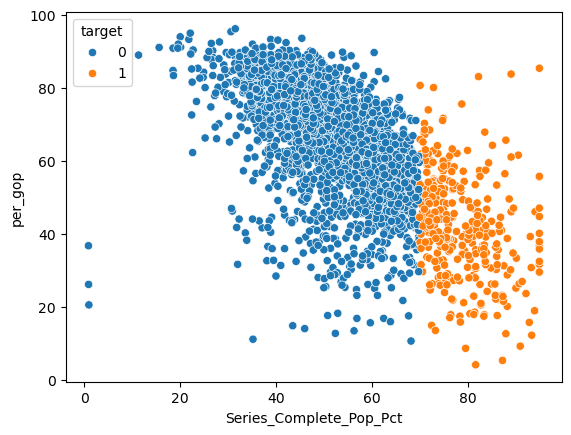

In [402]:
visual('per_gop')

On the left, the lower the percentage of republicans (lower on the graph), the more likely the county is to be orange (or herd immune)

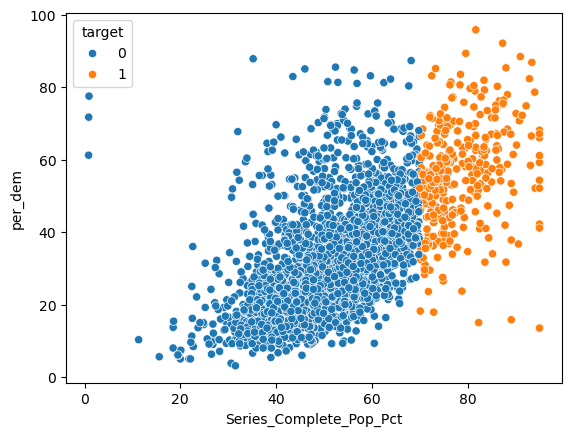

In [403]:
visual('per_dem')

On the right, the higher the percentage of democrats (or higher on the graph), the more likely the county is to be herd immune

This visually confirms that there is some potential relationship between party affiliation and vaccination, justifying our research question

Below we plot more of our predictors.

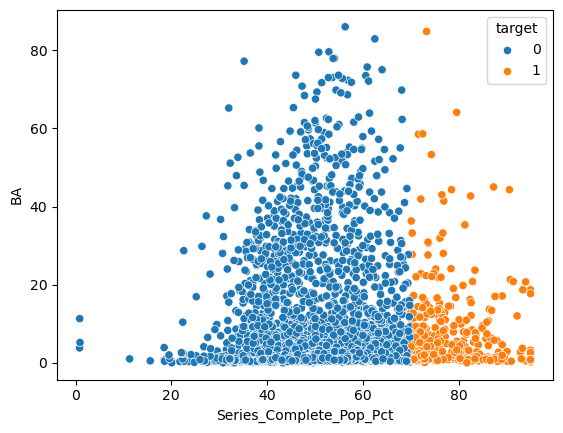

In [404]:
visual('BA')

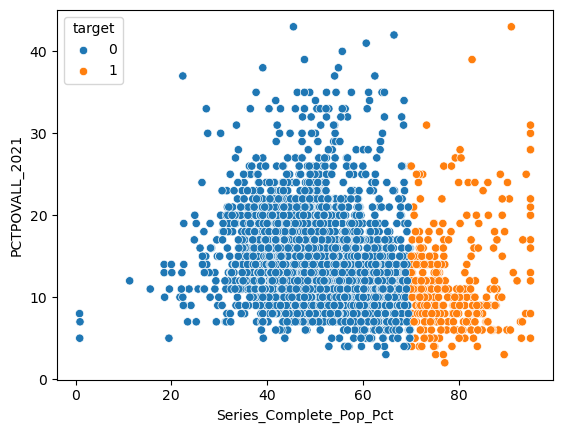

In [405]:
visual('PCTPOVALL_2021')

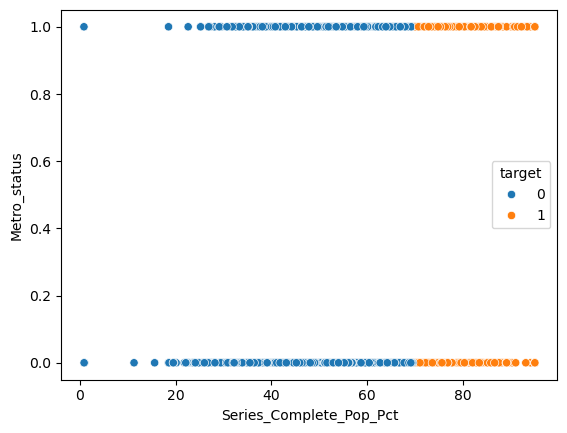

In [406]:
visual('Metro_status')

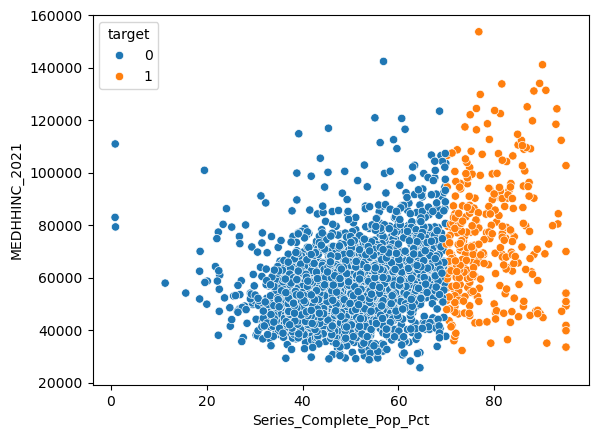

In [407]:
visual('MEDHHINC_2021')

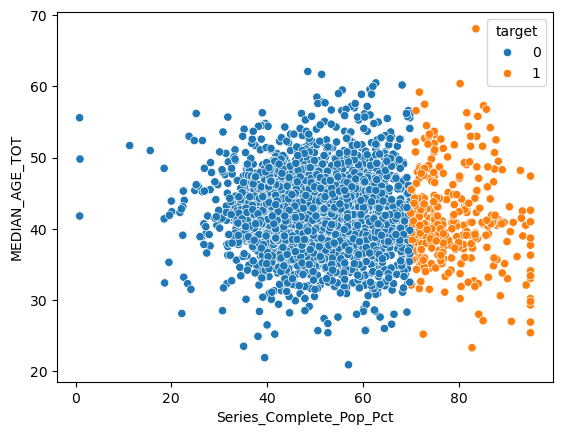

In [408]:
visual('MEDIAN_AGE_TOT')

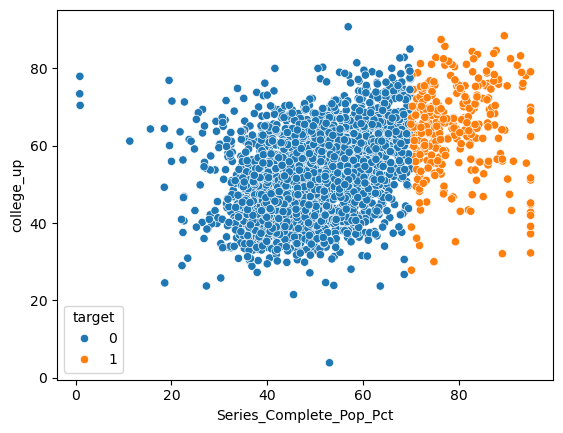

In [409]:
visual('college_up')

## 4. Modelling

In [342]:
#more imports
import seaborn as sns
from scipy import stats as stats

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.dummy import DummyClassifier

from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, \
confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV, \
cross_val_score, RandomizedSearchCV, cross_validate

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbPipeline

Our target (y) is the binary 'target' column with a 1 for having achieved a 70% vaccination rate (herd immunity).

Our predictors (X) are party affiliation in the 2020 election, metro status, poverty percentage, racial demographics, median age, educational attainment status.

In [343]:
# Setting up our X and y. Dropping our target and date columns, as well as the Series_Complete_Pop_Pct column, from which our target is calculated.
y = df['target']
X = df.drop(['target', 'County_with_State', 'Date', 'Series_Complete_Pop_Pct'], axis=1)

# We can see that our target is imbalanced, so we'll use SMOTE to correct for that. 
y.value_counts(normalize=True)

target
0    0.892708
1    0.107292
Name: proportion, dtype: float64

We split our data into training and test sets. The latter we keep from the model until the very end, so that its performance can be tested on unseen data.

In [344]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

Here we define:

1. The "cv_eval_model" function to cross-validate the model, outputting its training and testing accuracy and precision scores.

    * Precision is the metric we are most concerned with, because it measures true positives: when the model predicted a 1 (herd immunity achieved), what percent of the time was it right? Increasing precision means reducing false positives. Since the public health goal is to have achieved herd immunity, increasing precision is paramount.

2. The "plot_cm" function to plot the confusion matrix of the model's performance: comparing the model's predictions to the actual values. Confusion matrices show true positives, true negatives, false positives, and false negatives.

3. The "get_feature_importances" function to output, in descending order", the importances of each predictor in determining the most accurate splits of our tree models.

4. A "plot_feature_importances" function that graphs the above in a bar graph.

5. A "best_gs" function that outputs the cross-validation scores from the "cv_eval_model" function for a model that uses the best parameters decided by our grid search.

6. A "test_precision" function that outputs the precision score for the model's performance on test data.

In [345]:
# Create a custom function to cross validate and evaluate models, without having to touch our testing data.
def cv_eval_model(model, X_train, y_train):
    '''
    Takes in a model, training and testing data, and scoring metrics.
    Performs cv on training data and returns mean score.
    Fits model on the training data and returns the score on the test data.
    '''
    scoring = ['accuracy', 'precision']
    cv_scores = cross_validate(model, X_train, y_train, scoring=scoring, return_train_score=True)
    print(f'Training scores: {cv_scores}')
    print(f'Mean training accuracy: {cv_scores["train_accuracy"].mean()}')
    print(f'Mean training precision: {cv_scores["train_precision"].mean()}')
    print(f'Mean validation data accuracy: {cv_scores["test_accuracy"].mean()}')
    print(f'Mean validation data precision: {cv_scores["test_precision"].mean()}')
    
# Function that will calculate and plot our confusion matrices
def plot_cm(y_true, y_pred):
    '''
    Takes in true values and predicted values and plots a confusion matrix
    '''
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['<70% Vaccinated', '>70% Vaccinated'])
    disp.plot();

# Function to get the feature importances from a model
def get_feature_importances(model, X):
    importances = model.feature_importances_
    features = X.columns
    feature_importances = pd.DataFrame({'features': features, 'importances': importances})
    return feature_importances.sort_values('importances', ascending=False)

# Function to plot the feature importances
def plot_feature_importances(model, X):
    n_features = X.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')
    plt.show()

# Function to evaluate the best model outputted from gridsearch
def best_gs(gs_model):
    best_params = gs_model.best_params_
    estimator = gs_model.best_estimator_
    cv_eval_model(estimator, X_train, y_train)
  

### 4.a. Dummy Model

We'll start with a dummy model that simply predicts every instance to be the same as the most frequent; in this case, that means predicting everything as 0 (i.e., no counties will reach our herd immunity threshold), since, as we saw above, almost 9/10 of our targets are 0. It is for this reason that we'll end up balancing our model using synthetic data. 

For this model, our accuracy will be the same as the proportion of our test data for which the target variable is 0. Our precision, however -- the rate at which our predicted positive scores are, in reality, positive -- will be 0. We will be most concerned with maximizing this score.

In [346]:
dummy_model = DummyClassifier(strategy='most_frequent')
dummy_model.fit(X_train, y_train)

dummy_accuracy = dummy_model.score(X_train, y_train)
dummy_precision = precision_score(y_train, dummy_model.predict(X_train))

print('Dummy Accuracy: ', dummy_accuracy)
print('Dummy Precision: ', dummy_precision)

Dummy Accuracy:  0.8886032562125107
Dummy Precision:  0.0


/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


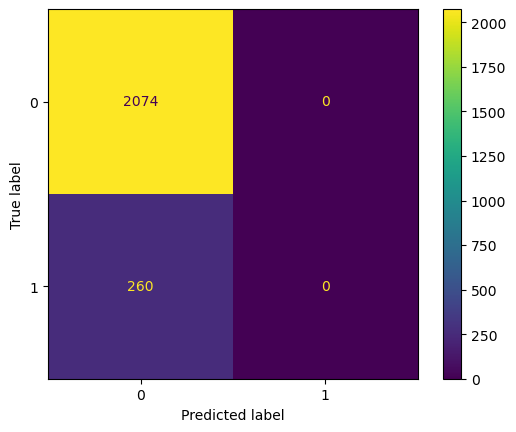

In [347]:
dummy_cm = confusion_matrix(y_train, dummy_model.predict(X_train))
ConfusionMatrixDisplay(dummy_cm).plot();

### 4.b. Decision Tree

#### 4.b.i. Baseline Decision Tree

In [397]:
dt_pipe = imbPipeline([
    ('std_scaler', StandardScaler()),
    ('smote', SMOTE(random_state=1)),
    ('dt', DecisionTreeClassifier(random_state=1))
])


cv_eval_model(dt_pipe, X_train, y_train)

Training scores: {'fit_time': array([0.03151226, 0.03100014, 0.02606177, 0.02397704, 0.0258801 ]), 'score_time': array([0.00214005, 0.00292301, 0.00164294, 0.0017519 , 0.00205016]), 'test_accuracy': array([0.85653105, 0.85438972, 0.88008565, 0.88008565, 0.88412017]), 'train_accuracy': array([1., 1., 1., 1., 1.]), 'test_precision': array([0.40963855, 0.4       , 0.46969697, 0.47142857, 0.48571429]), 'train_precision': array([1., 1., 1., 1., 1.])}
Mean training accuracy: 1.0
Mean training precision: 1.0
Mean validation data accuracy: 0.8710424497523228
Mean validation data precision: 0.4472956762113389


Our accuracy performs worse than our dummy model, and when our model predicts a positive -- i.e., that a county has been at least 70% vaccinated -- it is wrong more than half the time.

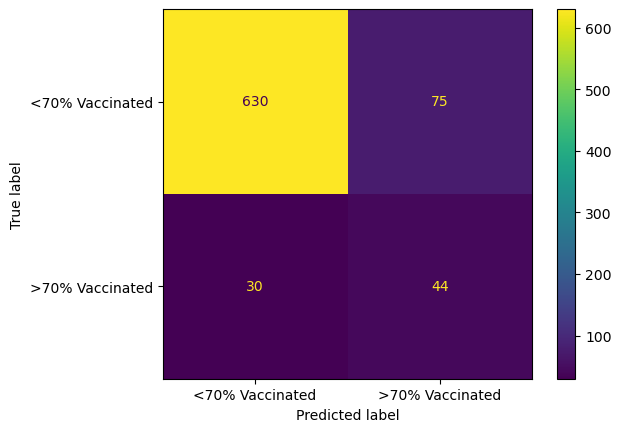

In [ ]:
y_pred = dt_pipe.fit(X_train, y_train).predict(X_test)
plot_cm(y_test, y_pred)

In [ ]:
get_feature_importances(dt_pipe['dt'], X)

,features,importances
0,per_gop,0.502467
7,BA,0.079743
5,MEDHHINC_2021,0.070693
8,IA,0.059181
10,MEDIAN_AGE_TOT,0.057416
1,per_dem,0.056549
4,PCTPOVALL_2021,0.043896
9,AAPI,0.037439
6,WA,0.034935
11,through_hs,0.026221


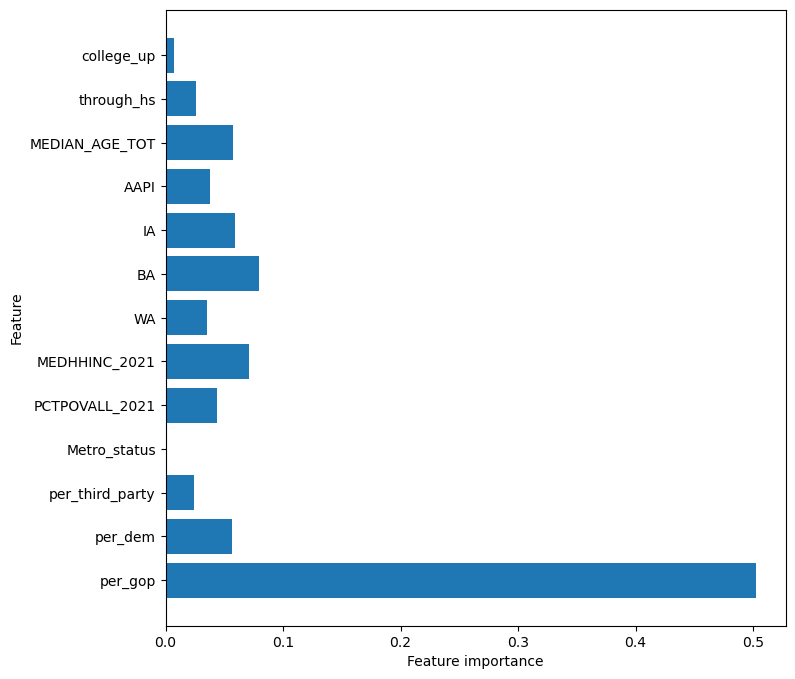

In [ ]:
plot_feature_importances(dt_pipe['dt'], X)

#### 4.b.ii Decision Tree Gridsearch

We'll now use a gridsearch to try to find the optimal hyperparameters for our model.

In [ ]:
dt_pipe = imbPipeline([
    ('std_scaler', StandardScaler()),
    ('smote', SMOTE(random_state=1)),
    ('dt', DecisionTreeClassifier(random_state=1))
])

pipe_grid = {'smote__k_neighbors': [5, 10, 20],
                'dt__max_depth': [None, 1, 5, 10],
                'dt__min_samples_split': [2, 5, 10],
                'dt__min_samples_leaf': [1, 2, 5, 10],
                'dt__ccp_alpha': [0, .001, .01, .1, 1]}

gs_pipe_dt = GridSearchCV(dt_pipe, pipe_grid, cv=5, scoring=['accuracy', 'recall', 'precision'], refit='precision', n_jobs=-2, verbose=1, return_train_score=True)
gs_pipe_dt.fit(X_train, y_train)

Fitting 5 folds for each of 720 candidates, totalling 3600 fits


/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('std_scaler', StandardScaler()),
                                       ('smote', SMOTE(random_state=1)),
                                       ('dt',
                                        DecisionTreeClassifier(random_state=1))]),
             n_jobs=-2,
             param_grid={'dt__ccp_alpha': [0, 0.001, 0.01, 0.1, 1],
                         'dt__max_depth': [None, 1, 5, 10],
                         'dt__min_samples_leaf': [1, 2, 5, 10],
                         'dt__min_samples_split': [2, 5, 10],
                         'smote__k_neighbors': [5, 10, 20]},
             refit='precision', scoring=['accuracy', 'recall', 'precision'],
             verbose=1)

In [ ]:
best_gs(gs_pipe_dt)

Training scores: {'fit_time': array([0.02971601, 0.02488136, 0.02356362, 0.02370811, 0.02449107]), 'score_time': array([0.00173211, 0.00175691, 0.00151229, 0.00184584, 0.00169492]), 'test_accuracy': array([0.85438972, 0.89507495, 0.90578158, 0.89507495, 0.89914163]), 'train_accuracy': array([0.97429031, 0.96946974, 0.97107659, 0.97589716, 0.96520343]), 'test_precision': array([0.41111111, 0.52459016, 0.55882353, 0.52238806, 0.54237288]), 'train_precision': array([0.84482759, 0.8212766 , 0.81300813, 0.86222222, 0.78714859])}
Mean training accuracy: 0.9711874447320703
Mean training precision: 0.8256966257265221
Mean validation data accuracy: 0.8898925660089512
Mean validation data precision: 0.5118571491029453


Our accuracy performs about the same as our dummy model, and when our model predicts a positive -- i.e., that a county has been at least 70% vaccinated -- it is correct just slightly more than half of the time.

### 4.c. Logarithmic Regression

#### 4.c.i. First Logarithmic Gridsearch

In order to try to improve these scores, we tried a different model type. Here we create a pipeline for our logistic regression model. It includes pre-processing such as scaling the data, instatiating the model, and SMOTE.

Scaling using StandardScaler() is necessary because not all of our data is in the same units. Logistic regressions include regularization -- a distance-based technique. If data was not scaled, the columns with larger units would be unfairly weighted higher; in other words, they would have a larger influence on our target.

This pipeline includes a grid search with 4 different hyperparameters. The grid search will run the pipeline 540 times with all possible different combinations of these hyperparameters, before outputting which parameters led to the highest accuracy score.

In [ ]:
pipe_lr = imbPipeline([
    ('std_scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42, sampling_strategy="minority", k_neighbors=10)),
    ('lr', LogisticRegression(random_state=1, max_iter=1000, penalty='l2', C=1e5))
])

pipe_grid_lr = {
    'smote__k_neighbors': [5, 10, 20],
    'lr__penalty': ['l1', 'l2'],
    'lr__C': [1e5, 1e3, 1, .1, .01, .001],
    'lr__solver': ['liblinear', 'saga', 'lbfgs']
}

gs_pipe_lr = GridSearchCV(pipe_lr, pipe_grid_lr, cv=5, scoring=['accuracy', 'recall', 'precision'], refit='precision', n_jobs=-2, verbose=1, return_train_score=True)
gs_pipe_lr.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not c

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('std_scaler', StandardScaler()),
                                       ('smote',
                                        SMOTE(k_neighbors=10, random_state=42,
                                              sampling_strategy='minority')),
                                       ('lr',
                                        LogisticRegression(C=100000.0,
                                                           max_iter=1000,
                                                           random_state=1))]),
             n_jobs=-2,
             param_grid={'lr__C': [100000.0, 1000.0, 1, 0.1, 0.01, 0.001],
                         'lr__penalty': ['l1', 'l2'],
                         'lr__solver': ['liblinear', 'saga', 'lbfgs'],
                         'smote__k_neighbors': [5, 10, 20]},
             refit='precision', return_train_score=True,
             scoring=['accuracy', 'recall', 'precision'], verbose=1)

In [ ]:
best_gs(gs_pipe_lr)

Training scores: {'fit_time': array([0.01158285, 0.01903224, 0.02034402, 0.01707697, 0.02060008]), 'score_time': array([0.00166917, 0.00147295, 0.00155282, 0.00124812, 0.00125408]), 'test_accuracy': array([0.86295503, 0.90364026, 0.88222698, 0.88650964, 0.88841202]), 'train_accuracy': array([0.88430637, 0.87948581, 0.88537761, 0.87787895, 0.8859743 ]), 'test_precision': array([0.44444444, 0.54545455, 0.48275862, 0.49484536, 0.5       ]), 'train_precision': array([0.48907104, 0.4772118 , 0.49184783, 0.47395833, 0.49326146])}
Mean training accuracy: 0.882604609072944
Mean training precision: 0.4850700898887822
Mean validation data accuracy: 0.8847487845897934
Mean validation data precision: 0.4935005942826775


In [398]:
y_pred = gs_pipe_lr.predict(X_test)
precision = precision_score(y_test, y_pred)
precision

0.43795620437956206

Our model with the best hyperparameters has an accuracy of 88% and a precision of 49% from its cross-validation. It has a precision of 44% on unseen test data. These values are worse than the decision tree.

#### 4.c.ii. Second Logarithmic Gridsearch

We tried to improve these scores using a second grid search with different hyperparameters.

In [ ]:
pipe_grid_lr2 = {
    'smote__k_neighbors': [2, 5, 10],
    'lr__penalty': ['l1', 'l2', 'elasticnet', None],
    'lr__C': [1e7, 1e5, 1e3],
    'lr__solver': ['liblinear', 'saga'],
    'lr__l1_ratio': [0, .25, .5, .75, 1]
}

gs_pipe_lr2 = GridSearchCV(pipe_lr, pipe_grid_lr2, cv=5, verbose=1, scoring=['accuracy', 'recall', 'precision'], refit='precision', n_jobs=-2)
gs_pipe_lr2.fit(X_train, y_train)

Fitting 5 folds for each of 360 candidates, totalling 1800 fits


/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('std_scaler', StandardScaler()),
                                       ('smote',
                                        SMOTE(k_neighbors=10, random_state=42,
                                              sampling_strategy='minority')),
                                       ('lr',
                                        LogisticRegression(C=100000.0,
                                                           max_iter=1000,
                                                           random_state=1))]),
             n_jobs=-2,
             param_grid={'lr__C': [10000000.0, 100000.0, 1000.0],
                         'lr__l1_ratio': [0, 0.25, 0.5, 0.75, 1],
                         'lr__penalty': ['l1', 'l2', 'elasticnet', None],
                         'lr__solver': ['liblinear', 'saga'],
                         'smote__k_neighbors': [2, 5, 10]},
             refit='precision', scoring=['accuracy', 'recall', 'precision'],
             verbose=1)

In [ ]:
best_gs(gs_pipe_lr2)

Training scores: {'fit_time': array([0.01213813, 0.00871778, 0.00871491, 0.00762296, 0.01172805]), 'score_time': array([0.00207281, 0.00147939, 0.00179315, 0.001405  , 0.00127888]), 'test_accuracy': array([0.86509636, 0.90578158, 0.87794433, 0.88650964, 0.88412017]), 'train_accuracy': array([0.89019818, 0.88377076, 0.88591323, 0.88055704, 0.88329764]), 'test_precision': array([0.44859813, 0.55128205, 0.47191011, 0.49484536, 0.48888889]), 'train_precision': array([0.50417827, 0.48780488, 0.49329759, 0.4801061 , 0.48641304])}
Mean training accuracy: 0.8847473703648057
Mean training precision: 0.4903599764869332
Mean validation data accuracy: 0.8838904154910809
Mean validation data precision: 0.49110490883927094


/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l

In [399]:
y_pred = gs_pipe_lr2.predict(X_test)
precision = precision_score(y_test, y_pred)
precision

0.45112781954887216

The scores did not change.

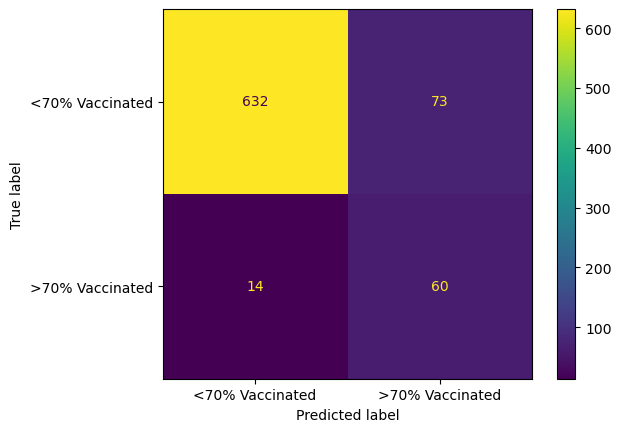

In [ ]:
plot_cm(y_test, gs_pipe_lr2.predict(X_test))

Unlike our tree-based models, the coefficients on the predictors from logistic regression can be used to get a sense of the direction in which each factor affected the likelihood of vaccination.

Because our data is scaled, each coefficient can be interpreted as such: a one standard deviation increase in the predictor leads to a "coefficient" sized change in probability of that county being herd immune (achieving a target class of 1).

Below we will visualize these coefficients.

In [ ]:
coefs_lr = gs_pipe_lr2.best_estimator_.named_steps['lr'].coef_
coefs_full_lr = pd.DataFrame({'features': X_train.columns, 'coefs': coefs_lr[0]}).set_index('features')
coefs_full_lr = coefs_full_lr.sort_values('coefs', ascending=False)
coefs_full_lr

,coefs
features,
WA,4.393717
BA,2.697628
IA,2.406721
AAPI,1.438023
MEDIAN_AGE_TOT,0.579556
MEDHHINC_2021,0.516319
PCTPOVALL_2021,0.076778
Metro_status,0.059664
through_hs,0.033534


/var/folders/gf/gqtw2hsd3xx5_9tt2z47xflr0000gn/T/ipykernel_96793/582933847.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y=coefs_full_lr.index, x=coefs_full_lr['coefs'], palette='coolwarm', )


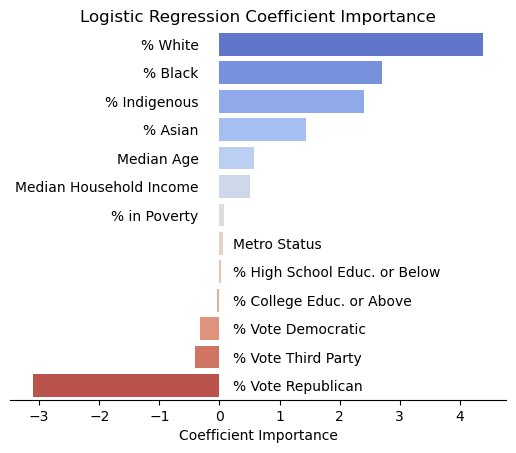

In [ ]:
new_features = ['% White', '% Black', '% Indigenous', '% Asian', 'Median Age', 'Median Household Income', '% in Poverty', 'Metro Status', '% High School Educ. or Below', '% College Educ. or Above', '% Vote Democratic',  '% Vote Third Party', '% Vote Republican']
coefs_full_lr.index = new_features
ax = sns.barplot(y=coefs_full_lr.index, x=coefs_full_lr['coefs'], palette='coolwarm', )
ax.set_ylabel('')
# Set the x tick labels position
ytick_labels = ax.get_yticklabels()

for i, label in enumerate(ytick_labels):
    if i < 7:
        label.set_x(.4)  
        
    else:
        label.set_x(.47) 
        label.set_horizontalalignment('left')
        
ax.set_xlabel('Coefficient Importance')

ax.set_title('Logistic Regression Coefficient Importance', fontsize=12)

ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.tick_params(left=False)

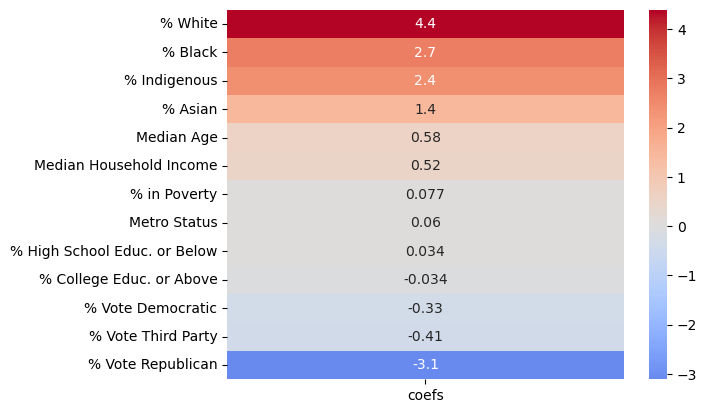

In [ ]:
ax = sns.heatmap(coefs_full_lr, annot=True, cmap='coolwarm', center=0)

In the above two graphs, our top two strongest predictors are the percentage of white citizens and the percentage of Republicans in that county.

Being more white makes a county more likely to have achieved full vaccination Being more republican makes a county less likely to have achieved full vaccination

### 4.d. Random Forest

Our logistic regression scores are worse than our decision tree scores. This may be because our data is non-linear. Non-linear data is highly likely because there is a high chance that some of our predictors are colinear. For example, the proportion of white citizens in a county is likely correlated with the amount of Republicans in that county. Therefore, we went back to tree-based models. Trees are not linear, so they don't need linear relationships to model. This also resolves our issues with multicolinearity.



In [ ]:
# More imports for the following models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier

Here we create a pipeline and four hyperparameter gridsearch for a Random Forest model.

In [ ]:
pipe_rf = imbPipeline([
    ('std_scaler', StandardScaler()),
    ('smote', SMOTE(random_state=1)),
    ('rf', RandomForestClassifier(random_state=1))
])

param_grid_rf={
        'rf__max_depth': [None, 5, 10],
        'rf__min_samples_split': [2, 5, 10],
        'rf__min_samples_leaf': [1, 5, 10],
        'rf__n_estimators': [100, 200, 300],
}

pipe_grid_rf = GridSearchCV(
    estimator=pipe_rf,
    param_grid=param_grid_rf,
    scoring=['accuracy', 'precision', 'recall'],
    refit='precision',
    cv=5,
    n_jobs=-2
)

pipe_grid_rf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('std_scaler', StandardScaler()),
                                       ('smote', SMOTE(random_state=1)),
                                       ('rf',
                                        RandomForestClassifier(random_state=1))]),
             n_jobs=-2,
             param_grid={'rf__max_depth': [None, 5, 10],
                         'rf__min_samples_leaf': [1, 5, 10],
                         'rf__min_samples_split': [2, 5, 10],
                         'rf__n_estimators': [100, 200, 300]},
             refit='precision', scoring=['accuracy', 'precision', 'recall'])

In [ ]:
best_gs(pipe_grid_rf)

Training scores: {'fit_time': array([1.24216771, 1.290133  , 1.18676805, 1.22154903, 1.22082901]), 'score_time': array([0.01680303, 0.01599216, 0.01546097, 0.01550579, 0.01593709]), 'test_accuracy': array([0.89721627, 0.92291221, 0.91648822, 0.93361884, 0.92060086]), 'train_accuracy': array([1., 1., 1., 1., 1.]), 'test_precision': array([0.525     , 0.66      , 0.6       , 0.66153846, 0.6119403 ]), 'train_precision': array([1., 1., 1., 1., 1.])}
Mean training accuracy: 1.0
Mean training precision: 1.0
Mean validation data accuracy: 0.9181672808815285
Mean validation data precision: 0.6116957520091848


In [400]:
y_pred = pipe_grid_rf.predict(X_test)
precision = precision_score(y_test, y_pred)
precision

0.5346534653465347

The Random Forest (RF) model is definitely an improvement upon the decision tree and logarithmic regression models. The model with the best hyperparameters has an accuracy score of 92% and a precision score of 61%. It has a precision score of 55% on the original unseen test data. Since this is an improvement on our logistic regression, so we are justified in continuing on with tree-based models.

### 4.e. Gradient Boosting

Here we create a pipeline and seven hyperparameter gridsearch for a Gradient Boosting model.

In [349]:
pipe_gb = imbPipeline([
    ('std_scaler', StandardScaler()),
    ('smote', SMOTE(random_state=1)),
    ('gb', GradientBoostingClassifier(random_state=1))
])

param_grid_gb={
        'smote__sampling_strategy': [0.5, 0.75, 1],
        'smote__k_neighbors': [3, 5, 7],
        'gb__max_depth': [None, 5, 10],
        'gb__min_samples_split': [2, 5, 10],
        'gb__min_samples_leaf': [1, 5, 10],
        'gb__n_estimators': [100, 200, 300],
        'gb__learning_rate': [0.1, 0.5, 1]
}

pipe_grid_gb = GridSearchCV(
    estimator=pipe_gb,
    param_grid=param_grid_gb,
    scoring=['accuracy', 'precision', 'recall'],
    refit='precision',
    cv=5,
    n_jobs=-2
)

pipe_grid_gb.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('std_scaler', StandardScaler()),
                                       ('smote', SMOTE(random_state=1)),
                                       ('gb',
                                        GradientBoostingClassifier(random_state=1))]),
             n_jobs=-2,
             param_grid={'gb__learning_rate': [0.1, 0.5, 1],
                         'gb__max_depth': [None, 5, 10],
                         'gb__min_samples_leaf': [1, 5, 10],
                         'gb__min_samples_split': [2, 5, 10],
                         'gb__n_estimators': [100, 200, 300],
                         'smote__k_neighbors': [3, 5, 7],
                         'smote__sampling_strategy': [0.5, 0.75, 1]},
             refit='precision', scoring=['accuracy', 'precision', 'recall'])

In [350]:
best_gs(pipe_grid_gb)

Training scores: {'fit_time': array([4.66878891, 4.67054486, 4.55414391, 4.58460093, 4.54343605]), 'score_time': array([0.00663209, 0.00586915, 0.00573111, 0.00616503, 0.00748491]), 'test_accuracy': array([0.93147752, 0.92933619, 0.92933619, 0.94860814, 0.92703863]), 'train_accuracy': array([1., 1., 1., 1., 1.]), 'test_precision': array([0.68518519, 0.72093023, 0.67272727, 0.80434783, 0.65517241]), 'train_precision': array([1., 1., 1., 1., 1.])}
Mean training accuracy: 1.0
Mean training precision: 1.0
Mean validation data accuracy: 0.9331593313176058
Mean validation data precision: 0.7076725860701314


In [389]:
pipe_grid_gb.best_params_

{'gb__learning_rate': 0.1,
 'gb__max_depth': 10,
 'gb__min_samples_leaf': 10,
 'gb__min_samples_split': 2,
 'gb__n_estimators': 300,
 'smote__k_neighbors': 5,
 'smote__sampling_strategy': 0.5}

In [351]:

y_pred = pipe_grid_gb.predict(X_test)
precision = precision_score(y_test, y_pred)
precision


0.6351351351351351

Our grid search of our Gradient Boosting pipeline resulted in a best model with an accuracy of 93% and a precision of 71% -- although it only had 63% accuracy on the testing data.

In [353]:
get_feature_importances(pipe_grid_gb.best_estimator_.named_steps['gb'], X)

,features,importances
1,per_dem,0.528664
5,MEDHHINC_2021,0.095606
7,BA,0.081004
8,IA,0.062388
10,MEDIAN_AGE_TOT,0.054799
9,AAPI,0.033338
2,per_third_party,0.031591
4,PCTPOVALL_2021,0.030271
0,per_gop,0.025827
6,WA,0.019935


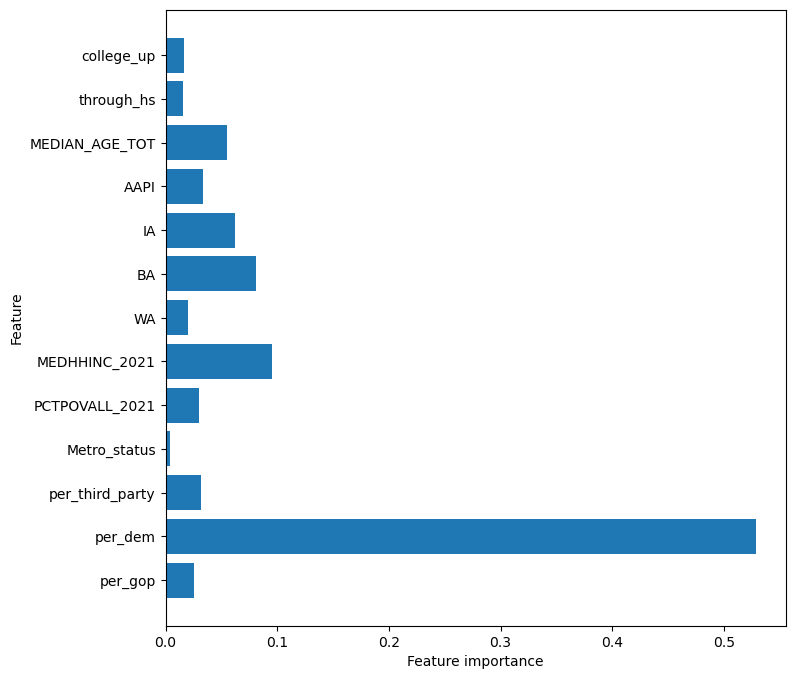

In [354]:
plot_feature_importances(pipe_grid_gb.best_estimator_.named_steps['gb'], X)

In [392]:
feature_importances = get_feature_importances(pipe_grid_gb.best_estimator_.named_steps['gb'], X)
feature_importances = feature_importances.sort_values('importances', ascending=False)
feature_importances

,features,importances
1,per_dem,0.528664
5,MEDHHINC_2021,0.095606
7,BA,0.081004
8,IA,0.062388
10,MEDIAN_AGE_TOT,0.054799
9,AAPI,0.033338
2,per_third_party,0.031591
4,PCTPOVALL_2021,0.030271
0,per_gop,0.025827
6,WA,0.019935


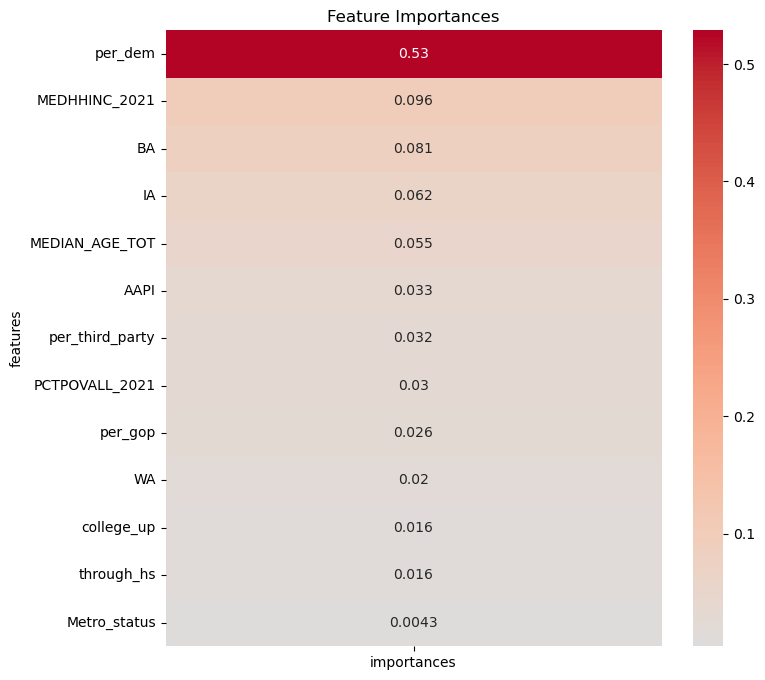

In [395]:
plt.figure(figsize=(8, 8))
sns.heatmap(feature_importances.set_index('features'), annot=True, cmap='coolwarm', center=0)
plt.title('Feature Importances')
plt.show()


The Gradient Boosting (GB) model performs better than the previous models; shortly, we will try a few different ways of tuning this model to try and find the best version. We can see that it performs better in both accuracy and precision (although the precision still admittedly leaves something to be desired). We can also see that the most important factor for this model is the percentage of the county that voted for Biden in the 2020 election; the other factors pale in comparison.

### 4.f. AdaBoost

Here we create a pipeline and two hyperparameter gridsearch for a Ada Boost model.

In [356]:
pipe_ada = imbPipeline([
    ('std_scaler', StandardScaler()),
    ('smote', SMOTE(random_state=1)),
    ('ada', AdaBoostClassifier(random_state=1))
])

param_grid_ada={
        'ada__learning_rate': [0.1, 0.5, 1],
        'ada__n_estimators': [50, 100, 200],
}

pipe_grid_ada = GridSearchCV(
    estimator=pipe_ada,
    param_grid=param_grid_ada,
    scoring=['accuracy', 'precision', 'recall'],
    refit='precision',
    cv=5,
    n_jobs=-2
)

pipe_grid_ada.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('std_scaler', StandardScaler()),
                                       ('smote', SMOTE(random_state=1)),
                                       ('ada',
                                        AdaBoostClassifier(random_state=1))]),
             n_jobs=-2,
             param_grid={'ada__learning_rate': [0.1, 0.5, 1],
                         'ada__n_estimators': [50, 100, 200]},
             refit='precision', scoring=['accuracy', 'precision', 'recall'])

In [357]:
best_gs(pipe_grid_ada)

Training scores: {'fit_time': array([0.66248822, 0.66340709, 0.64813471, 0.64554596, 0.65160608]), 'score_time': array([0.01335788, 0.01357102, 0.01312804, 0.01286912, 0.01310802]), 'test_accuracy': array([0.88436831, 0.9143469 , 0.89079229, 0.90578158, 0.91845494]), 'train_accuracy': array([0.93036958, 0.93893948, 0.9309052 , 0.93304767, 0.93522484]), 'test_precision': array([0.48809524, 0.59677419, 0.50617284, 0.55      , 0.60294118]), 'train_precision': array([0.63829787, 0.67028986, 0.63573883, 0.64359862, 0.65156794])}
Mean training accuracy: 0.9336973513830316
Mean training precision: 0.6478986238391672
Mean validation data accuracy: 0.902748802970288
Mean validation data precision: 0.5487966895240773


In [358]:
y_pred = pipe_grid_ada.predict(X_test)
precision = precision_score(y_test, y_pred)
precision

0.46078431372549017

The scores on the best model are: 65% accuracy, 55% precision on the cross-validation test data, and46% precision on the orignal unseen test data. It performs significantly worse than our GB model.

### 4.g. Gradient Boosting II

Because the accuracy and precision scores were best on our Gradient Boosting Model, we will run four more pipelines with different hyperparameter searches, basing the next one off of the best from the previous, in order to zoom in on the best hyperparameters.

In this pipeline we remove the max_depth parameter because the best value from our first Gradient Boosting pipeline was 'None'.

For the sake of runtime, we kept the best value for min_samples_split from the first pipeline.

We added smote__sampling_strategy, smote__k_neighbors, n_estimators, learning_rate, and subsample hyperparameters.

In [359]:
pipe_gb2 = imbPipeline([
    ('std_scaler', StandardScaler()),
    ('smote', SMOTE(random_state=1)),
    ('gb', GradientBoostingClassifier(random_state=1))
])
"""
Previous best params:
{'gb__max_depth': None,
 'gb__min_samples_leaf': 10,
 'gb__min_samples_split': 2,
 'gb__n_estimators': 300}
"""
param_grid_gb2={
        'smote__sampling_strategy': [0.5, 0.75, 1],
        'smote__k_neighbors': [3, 5, 7],
        # 'gb__max_depth': [None, 5, 10], - best is None, so getting rid of this param
        'gb__min_samples_split': [2], # did best with 2; getting rid of the others for sake of run time
        'gb__min_samples_leaf': [1, 10, 20],
        'gb__n_estimators': [300, 400, 500],
        'gb__learning_rate': [0.1, 0.5, 1],
        'gb__subsample': [0.5, 0.75, 1], # adding subsampling to see if it helps with overfitting
}

pipe_grid_gb2 = GridSearchCV(
    estimator=pipe_gb2,
    param_grid=param_grid_gb2,
    scoring=['accuracy', 'precision', 'recall'],
    refit='precision',
    cv=5,
    n_jobs=-2
)

pipe_grid_gb2.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('std_scaler', StandardScaler()),
                                       ('smote', SMOTE(random_state=1)),
                                       ('gb',
                                        GradientBoostingClassifier(random_state=1))]),
             n_jobs=-2,
             param_grid={'gb__learning_rate': [0.1, 0.5, 1],
                         'gb__min_samples_leaf': [1, 10, 20],
                         'gb__min_samples_split': [2],
                         'gb__n_estimators': [300, 400, 500],
                         'gb__subsample': [0.5, 0.75, 1],
                         'smote__k_neighbors': [3, 5, 7],
                         'smote__sampling_strategy': [0.5, 0.75, 1]},
             refit='precision', scoring=['accuracy', 'precision', 'recall'])

In [360]:
best_gs(pipe_grid_gb2)

Training scores: {'fit_time': array([2.56955791, 2.51352501, 2.50762796, 2.49929667, 2.53314304]), 'score_time': array([0.00349379, 0.00367403, 0.00326991, 0.00339413, 0.0049479 ]), 'test_accuracy': array([0.91862955, 0.93576017, 0.91862955, 0.94860814, 0.93562232]), 'train_accuracy': array([1., 1., 1., 1., 1.]), 'test_precision': array([0.61666667, 0.75      , 0.61666667, 0.80434783, 0.7037037 ]), 'train_precision': array([1., 1., 1., 1., 1.])}
Mean training accuracy: 1.0
Mean training precision: 1.0
Mean validation data accuracy: 0.9314499453180286
Mean validation data precision: 0.6982769726247987


In [386]:
pipe_grid_gb2.best_params_

{'gb__learning_rate': 0.5,
 'gb__min_samples_leaf': 10,
 'gb__min_samples_split': 2,
 'gb__n_estimators': 500,
 'gb__subsample': 1,
 'smote__k_neighbors': 5,
 'smote__sampling_strategy': 0.5}

In [361]:
y_pred = pipe_grid_gb2.predict(X_test)
precision = precision_score(y_test, y_pred)
precision

0.6301369863013698

The scores on the best model are: 93% accuracy, 70% precision on the cross-validation test data, and 63% precision on the orignal unseen test data

In [381]:
get_feature_importances(pipe_grid_gb2.best_estimator_.named_steps['gb'], X)

,features,importances
1,per_dem,0.597561
5,MEDHHINC_2021,0.077242
8,IA,0.068692
7,BA,0.057050
10,MEDIAN_AGE_TOT,0.041937
4,PCTPOVALL_2021,0.036012
0,per_gop,0.032930
9,AAPI,0.032804
2,per_third_party,0.020353
11,through_hs,0.012099


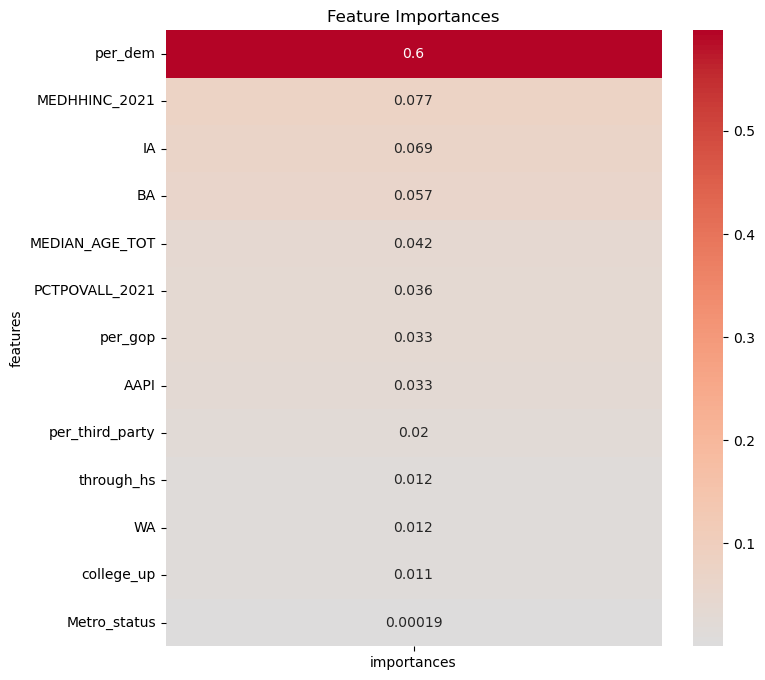

In [385]:
feature_importances = get_feature_importances(pipe_grid_gb2.best_estimator_.named_steps['gb'], X)
feature_importances = feature_importances.sort_values('importances', ascending=False)

plt.figure(figsize=(8,8))
sns.heatmap(feature_importances.set_index('features'), annot=True, cmap='coolwarm', center=0)
plt.title('Feature Importances')
plt.show()



### 4.h. Gradient Boosting III

Taking the best hyperparameters from the previous pipeline and zooming in further on those values. We are searching for the exact best hyperparameters.

In [363]:



pipe_gb3 = imbPipeline([
    ('std_scaler', StandardScaler()),
    ('smote', SMOTE(random_state=1)),
    ('gb', GradientBoostingClassifier(random_state=1))
])

"""
GB1 best params:
{'gb__max_depth': None,
 'gb__min_samples_leaf': 10,
 'gb__min_samples_split': 2,
 'gb__n_estimators': 300}

GB2 best params:
{'gb__learning_rate': 0.5,
 'gb__min_samples_leaf': 1,
 'gb__min_samples_split': 2,
 'gb__n_estimators': 400,
 'smote__k_neighbors': 5,
 'smote__sampling_strategy': 0.5}
"""


param_grid_gb3={
        'smote__sampling_strategy': [0.5, 0.75, 1],
        'smote__k_neighbors': [3, 5, 7],
        # 'gb__max_depth': [None, 5, 10], - best is None, so getting rid of this param
        'gb__min_samples_split': [2], # did best with 2; getting rid of the others for sake of run time
        'gb__min_samples_leaf': [1, 10],
        'gb__n_estimators': [300, 400, 500],
        'gb__learning_rate': [0.1, 0.5, 1],
        'gb__subsample': [0.5, 0.75, 1], # adding subsampling to see if it helps with overfitting
}

pipe_grid_gb3 = GridSearchCV(
    estimator=pipe_gb3,
    param_grid=param_grid_gb3,
    scoring=['accuracy', 'precision', 'recall'],
    refit='precision',
    cv=5,
    n_jobs=-1
)

pipe_grid_gb3.fit(X_train, y_train)



GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('std_scaler', StandardScaler()),
                                       ('smote', SMOTE(random_state=1)),
                                       ('gb',
                                        GradientBoostingClassifier(random_state=1))]),
             n_jobs=-1,
             param_grid={'gb__learning_rate': [0.1, 0.5, 1],
                         'gb__min_samples_leaf': [1, 10],
                         'gb__min_samples_split': [2],
                         'gb__n_estimators': [300, 400, 500],
                         'gb__subsample': [0.5, 0.75, 1],
                         'smote__k_neighbors': [3, 5, 7],
                         'smote__sampling_strategy': [0.5, 0.75, 1]},
             refit='precision', scoring=['accuracy', 'precision', 'recall'])

In [364]:
best_gs(pipe_grid_gb3)

Training scores: {'fit_time': array([2.77213502, 2.81228709, 2.73950577, 2.73474574, 2.73840976]), 'score_time': array([0.00412202, 0.00358081, 0.00361133, 0.00378418, 0.00361443]), 'test_accuracy': array([0.91862955, 0.93576017, 0.91862955, 0.94860814, 0.93562232]), 'train_accuracy': array([1., 1., 1., 1., 1.]), 'test_precision': array([0.61666667, 0.75      , 0.61666667, 0.80434783, 0.7037037 ]), 'train_precision': array([1., 1., 1., 1., 1.])}
Mean training accuracy: 1.0
Mean training precision: 1.0
Mean validation data accuracy: 0.9314499453180286
Mean validation data precision: 0.6982769726247987


In [369]:
pipe_grid_gb3.best_params_

{'gb__learning_rate': 0.5,
 'gb__min_samples_leaf': 10,
 'gb__min_samples_split': 2,
 'gb__n_estimators': 500,
 'gb__subsample': 1,
 'smote__k_neighbors': 5,
 'smote__sampling_strategy': 0.5}

In [365]:
y_pred = pipe_grid_gb3.predict(X_test)
precision = precision_score(y_test, y_pred)
precision

0.6301369863013698

The scores on the best model are: 93% accuracy, 70% precision on the cross-validation test data, and 63% precision on the orignal unseen test data

In [366]:
get_feature_importances(pipe_grid_gb3.best_estimator_.named_steps['gb'], X)

,features,importances
1,per_dem,0.597561
5,MEDHHINC_2021,0.077242
8,IA,0.068692
7,BA,0.057050
10,MEDIAN_AGE_TOT,0.041937
4,PCTPOVALL_2021,0.036012
0,per_gop,0.032930
9,AAPI,0.032804
2,per_third_party,0.020353
11,through_hs,0.012099


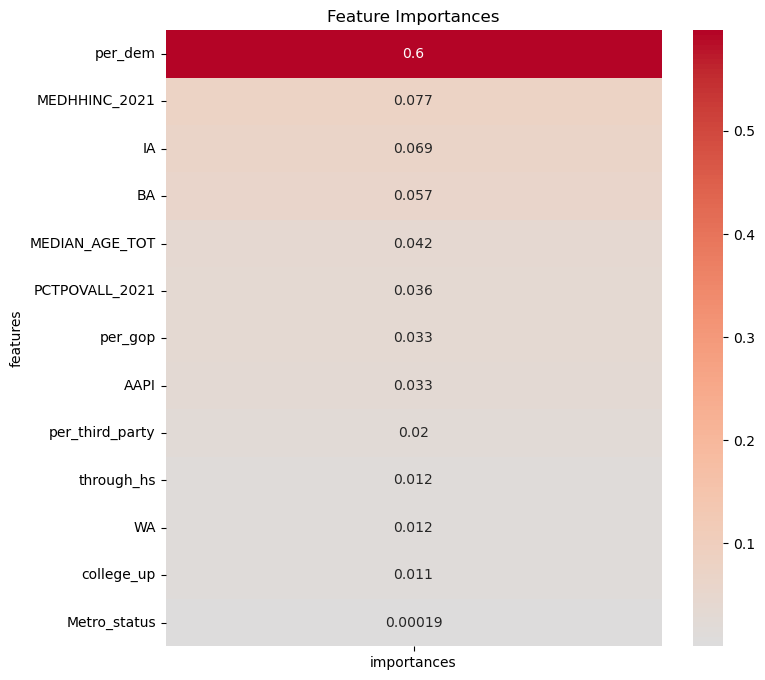

In [368]:

plot_feature_importances(pipe_grid_gb3.best_estimator_.named_steps['gb'], X)
feature_importances = get_feature_importances(pipe_grid_gb3.best_estimator_.named_steps['gb'], X)
feature_importances = feature_importances.sort_values('importances', ascending=False)

plt.figure(figsize=(8, 8))
sns.heatmap(feature_importances.set_index('features'), annot=True, cmap='coolwarm', center=0)
plt.title('Feature Importances')
plt.show()


### 4.i. Gradient Boosting IV

In [371]:



pipe_gb4 = imbPipeline([
    ('std_scaler', StandardScaler()),
    ('smote', SMOTE(random_state=1)),
    ('gb', GradientBoostingClassifier(random_state=1))
])

"""
GB1 best params:
{'gb__max_depth': None,
 'gb__min_samples_leaf': 10,
 'gb__min_samples_split': 2,
 'gb__n_estimators': 300}

GB2 best params:
{'gb__learning_rate': 0.5,
 'gb__min_samples_leaf': 1,
 'gb__min_samples_split': 2,
 'gb__n_estimators': 400,
 'smote__k_neighbors': 5,
 'smote__sampling_strategy': 0.5}
"""


param_grid_gb4={
        #'smote__sampling_strategy': [0.5, 0.75, 1],
        #'smote__k_neighbors': [3, 5, 7],
        # 'gb__max_depth': [None, 5, 10], - best is None, so getting rid of this param
        'gb__min_samples_split': [2], # did best with 2; getting rid of the others for sake of run time
        'gb__min_samples_leaf': [1, 5, 10],
        'gb__n_estimators': [300, 400, 500],
        'gb__learning_rate': [0.1, 0.5, 1],
        'gb__subsample': [0.5, 0.75, 1], # adding subsampling to see if it helps with overfitting
}

pipe_grid_gb4 = GridSearchCV(
    estimator=pipe_gb4,
    param_grid=param_grid_gb4,
    scoring=['accuracy', 'precision', 'recall'],
    refit='precision',
    cv=5,
    n_jobs=-1
)

pipe_grid_gb4.fit(X_train, y_train)



GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('std_scaler', StandardScaler()),
                                       ('smote', SMOTE(random_state=1)),
                                       ('gb',
                                        GradientBoostingClassifier(random_state=1))]),
             n_jobs=-1,
             param_grid={'gb__learning_rate': [0.1, 0.5, 1],
                         'gb__min_samples_leaf': [1, 5, 10],
                         'gb__min_samples_split': [2],
                         'gb__n_estimators': [300, 400, 500],
                         'gb__subsample': [0.5, 0.75, 1]},
             refit='precision', scoring=['accuracy', 'precision', 'recall'])

In [372]:
best_gs(pipe_grid_gb4)

Training scores: {'fit_time': array([3.21034598, 3.07340169, 3.02967763, 2.99108195, 3.14217401]), 'score_time': array([0.00405025, 0.00321317, 0.00321722, 0.00308514, 0.00335407]), 'test_accuracy': array([0.9143469 , 0.92719486, 0.91220557, 0.95074946, 0.93776824]), 'train_accuracy': array([1., 1., 1., 1., 1.]), 'test_precision': array([0.58571429, 0.70454545, 0.59322034, 0.80851064, 0.70175439]), 'train_precision': array([1., 1., 1., 1., 1.])}
Mean training accuracy: 1.0
Mean training precision: 1.0
Mean validation data accuracy: 0.9284530056703826
Mean validation data precision: 0.6787490207011151


In [387]:
pipe_grid_gb4.best_params_

{'gb__learning_rate': 0.5,
 'gb__min_samples_leaf': 10,
 'gb__min_samples_split': 2,
 'gb__n_estimators': 400,
 'gb__subsample': 1}

In [376]:
y_pred = pipe_grid_gb4.predict(X_test)
precision = precision_score(y_test, y_pred)
precision

0.5454545454545454

The scores on the best model are: 93% accuracy, 68% precision on the cross-validation test data, and 55% precision on the orignal unseen test data

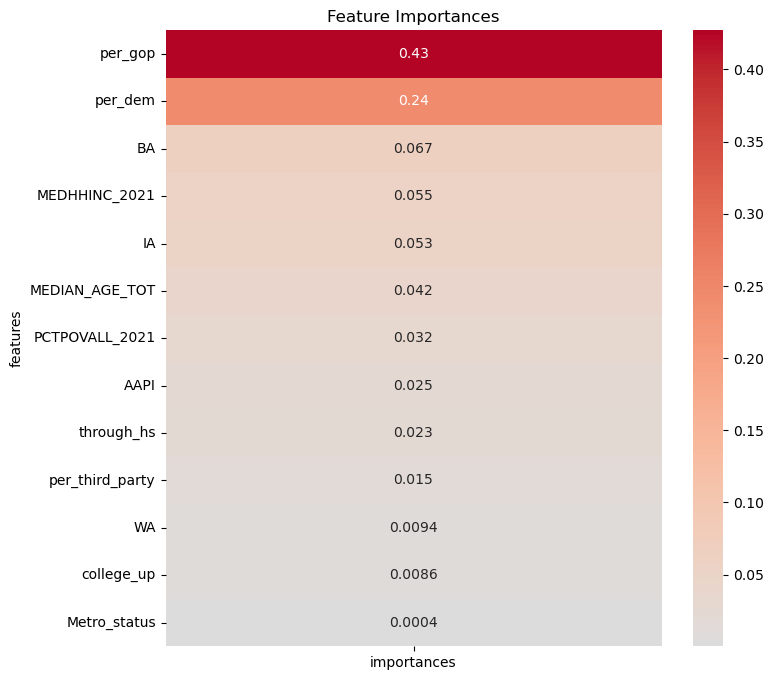

In [373]:

feature_importances = get_feature_importances(pipe_grid_gb4.best_estimator_.named_steps['gb'], X)
feature_importances = feature_importances.sort_values('importances', ascending=False)

plt.figure(figsize=(8, 8))
sns.heatmap(feature_importances.set_index('features'), annot=True, cmap='coolwarm', center=0)
plt.title('Feature Importances')
plt.show()


### 4.j. Gradient Boosting V

In [375]:



pipe_gb5 = imbPipeline([
    ('std_scaler', StandardScaler()),
    ('smote', SMOTE(random_state=1)),
    ('gb', GradientBoostingClassifier(random_state=1))
])

param_grid_gb5={
        'smote__sampling_strategy': [0.5],
        'smote__k_neighbors': [5],
        # 'gb__max_depth': [None, 5, 10], - best is None, so getting rid of this param
        'gb__min_samples_split': [2], # did best with 2; getting rid of the others for sake of run time
        'gb__min_samples_leaf': [1],
        'gb__n_estimators': [300, 400, 500],
        'gb__learning_rate': [0.1, 0.5, 1],
        'gb__subsample': [0.5, 0.75, 1], # adding subsampling to see if it helps with overfitting
}

pipe_grid_gb5 = GridSearchCV(
    estimator=pipe_gb5,
    param_grid=param_grid_gb5,
    scoring=['accuracy', 'precision', 'recall'],
    refit='precision',
    cv=5,
    n_jobs=-1
)

pipe_grid_gb5.fit(X_train, y_train)



GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('std_scaler', StandardScaler()),
                                       ('smote', SMOTE(random_state=1)),
                                       ('gb',
                                        GradientBoostingClassifier(random_state=1))]),
             n_jobs=-1,
             param_grid={'gb__learning_rate': [0.1, 0.5, 1],
                         'gb__min_samples_leaf': [1],
                         'gb__min_samples_split': [2],
                         'gb__n_estimators': [300, 400, 500],
                         'gb__subsample': [0.5, 0.75, 1],
                         'smote__k_neighbors': [5],
                         'smote__sampling_strategy': [0.5]},
             refit='precision', scoring=['accuracy', 'precision', 'recall'])

In [377]:
best_gs(pipe_grid_gb5)

Training scores: {'fit_time': array([2.76062703, 2.69179177, 2.70281792, 2.6723001 , 2.70410919]), 'score_time': array([0.0034821 , 0.00340509, 0.00345802, 0.00343394, 0.00354004]), 'test_accuracy': array([0.91648822, 0.92933619, 0.92077088, 0.94004283, 0.92918455]), 'train_accuracy': array([0.99946438, 1.        , 1.        , 1.        , 1.        ]), 'test_precision': array([0.6       , 0.71111111, 0.63157895, 0.77272727, 0.67924528]), 'train_precision': array([0.99521531, 1.        , 1.        , 1.        , 1.        ])}
Mean training accuracy: 0.9998928762720943
Mean training precision: 0.999043062200957
Mean validation data accuracy: 0.927164532997583
Mean validation data precision: 0.6789325228451345


In [388]:
pipe_grid_gb5.best_params_

{'gb__learning_rate': 0.5,
 'gb__min_samples_leaf': 1,
 'gb__min_samples_split': 2,
 'gb__n_estimators': 500,
 'gb__subsample': 1,
 'smote__k_neighbors': 5,
 'smote__sampling_strategy': 0.5}

In [378]:
y_pred = pipe_grid_gb5.predict(X_test)
precision = precision_score(y_test, y_pred)
precision

0.5616438356164384

The scores on the best model are: 93% accuracy, 68% precision on the cross-validation test data, and 56% precision on the orignal unseen test data

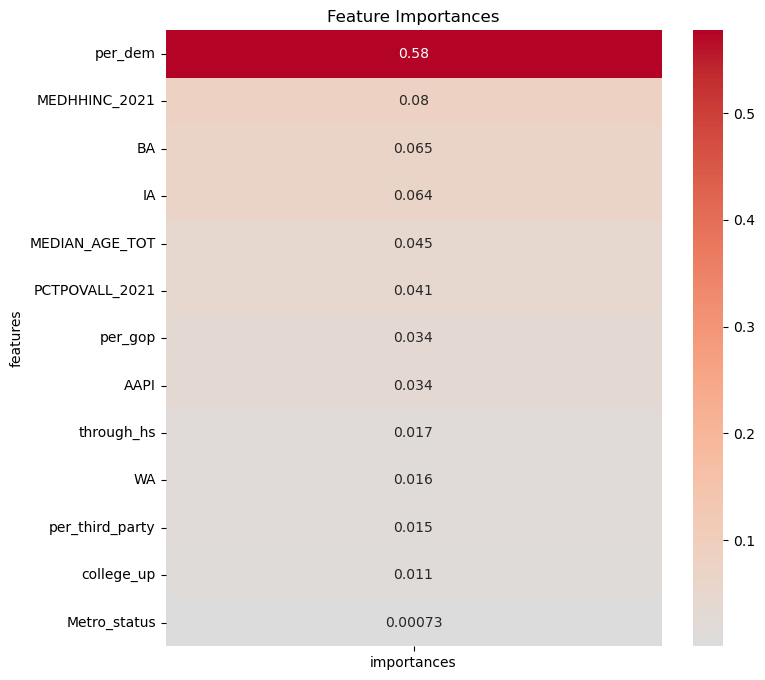

In [379]:
feature_importances = get_feature_importances(pipe_grid_gb5.best_estimator_.named_steps['gb'], X)
feature_importances = feature_importances.sort_values('importances', ascending=False)

plt.figure(figsize=(8, 8))
sns.heatmap(feature_importances.set_index('features'), annot=True, cmap='coolwarm', center=0)
plt.title('Feature Importances')
plt.show()


## 5. Interpreting Our Results

The best model ended up being the gradient boost with the following hyperparameters:

{'gb__learning_rate': 0.5,

 'gb__min_samples_leaf': 10,

 'gb__min_samples_split': 2,

 'gb__n_estimators': 500,

 'gb__subsample': 1,

 'smote__k_neighbors': 5,
 
 'smote__sampling_strategy': 0.5}



The results? Our model performs fairly well. While we correctly predicted whether or not a county would reach herd immunity 93% of the time, that may not be the best metric, since a model that just predicted that every county failed to reach herd immunity would also be right about 9/10 times.

The precision score on your screen is more informative: it tells us that when our model predicted herd immunity was achieved, it was correct 63% of the time.

The most important feature of this model was the percentage of the county that voted for Biden in the 2020 presidential election.

## 6. Impact of the Model

Public health efforts need to be informed by accurate data on heterogenous vaccination results so that providers can shape outreach to maximize positive outcomes. Having a predictive model for vaccination level can inform how we respond to future diseases. When we know what characteristics make vaccination less likely, we can changing the shape of our vaccine outreach in order to increase vaccination rates.

For example, if being Republican makes a person less likely to get vaccinated, we need to cater the media dialogue surrounding safety and efficacy to that group. Furthermore, based on the racial disparity in vaccination rates, achieving healthcare equity may require focusing manpower, medical supplies, etc. on the more vulnerable populations.

Therefore, this model can change how medical public relations is done, who medical providers and the government targets, logistical realities of medical infrastructure, and more.

Ultimately this model can contribute to an ongoing debate about healthcare and race, wealth, and importantly political affiliation - the very question that sparked our interest in this research.

## 7. Next Steps

There is exciting potential for further research should more county-level demographic data become available. Inputting other potential predictors of vaccinations could bring the precision and accuracy of our model higher up. Finding weak/less predictive data would also be informative.

Other factors we were interested in, but did not find data for include:

* Vaccine access, which could be represented through measures of medical provider densities in each county. Locations of hospitals, CVS's and other pharmacies, number of doctors, etc.
* Death rates are available per state, but not by county ([Johns Hopkins Interactive Map](https://coronavirus.jhu.edu/us-map)). They could help us ask whether more deaths led to higher vaccination.
* Unemployment data could help us answer whether higher unemployment meant more time for people to get vaccinated and fewer infections due to less interaction.
* Surveys and metrics measuring social and cultural attitudes toward medical institutions.

Data that was available but not included in this iteration of our model:
* CDC vaccination statuses by age could help us see differences in vaccination statuses between the different generations. Were younger people more likely to be vaccinated?
* The CDC also provides a Social Vulnerability Index (SVI).

Thank you for your interest in our resarch. Please feel free to contact us with any inquiries!

Shelley Wang
* shelleylwang@gmail.com
* [LinkedIn](https://www.linkedin.com/in/shelleywang22/)

Nate Hiatt
* natehiatt@gmail.com
* [LinkedIn](https://www.linkedin.com/in/nate-hiatt-107a9a82/)

https://github.com/natehiatt/covid_vax_project